In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import pandas_profiling as pdp
from pathlib import Path
from itertools import combinations
from tqdm import tqdm_notebook

import lda
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

In [2]:
DATA = Path("../data/input/")

df_train_transaction = pd.read_feather(DATA / "train_transaction.feather")
df_train_identity = pd.read_feather(DATA / "train_identity.feather")

df_test_transaction = pd.read_feather(DATA / "test_transaction.feather")
df_test_identity = pd.read_feather(DATA / "test_identity.feather")

df_sample = pd.read_csv(DATA / "sample_submission.csv")

print(f"train_transaction: {df_train_transaction.shape}")
print(f"train_identity: {df_train_identity.shape}")

print(f"test_transactino: {df_test_transaction.shape}")
print(f"test_identity: {df_test_identity.shape}")

train_transaction: (590540, 394)
train_identity: (144233, 41)
test_transactino: (506691, 393)
test_identity: (141907, 41)


In [3]:
df_train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,None,None,None,M0,T,T,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,

In [4]:
def concat(tr, te, feats):
    whole = pd.concat([tr[feats], te[feats]], axis=0).reset_index(drop=True)
    return whole

def bar_plot(col):
    print('train unique_num: ', df_train_transaction[col].unique().shape[0])
    print('test unique_num: ', df_test_transaction[col].unique().shape[0])

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    sns.distplot(df_train_transaction[col].dropna().values)
    plt.title('train')

    plt.subplot(2, 2, 2)
    sns.distplot(df_test_transaction[col].iloc[int(len(df_test_transaction) * 0.2):].dropna().values)
    plt.title('test')

    plt.subplot(2, 2, 3)
    sns.distplot(df_train_transaction[df_train_transaction['isFraud'] == 1][col].dropna().values)
    plt.title('isFraud')
    
    plt.subplot(2, 2, 4)
    sns.distplot(df_test_transaction[col].iloc[:int(len(df_test_transaction) * 0.2)].dropna().values)
    plt.title('July')
    
    
def bar_cat_plot(col):
    df_tr_count = df_train_transaction[col].value_counts().reset_index().rename(columns={'index': col, col: 'count_'})
    df_te_count = df_test_transaction[col].iloc[int(len(df_test_transaction) * 0.2):].value_counts().reset_index().rename(columns={'index': col, col: 'count_'})
    df_fraud_count = df_train_transaction[df_train_transaction['isFraud'] == 1][col].value_counts().reset_index().rename(columns={'index': col, col: 'count_'})
    df_july = df_test_transaction[col].iloc[:int(len(df_test_transaction) * 0.2)].value_counts().reset_index().rename(columns={'index': col, col: 'count_'})

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.bar(df_tr_count[col].values, df_tr_count['count_'])
    plt.title('train')

    plt.subplot(2, 2, 2)
    plt.bar(df_te_count[col].values, df_te_count['count_'])
    plt.title('test')

    plt.subplot(2, 2, 3)
    plt.bar(df_fraud_count[col].values, df_fraud_count['count_'])
    plt.title('fraud')
    
    plt.subplot(2, 2, 4)
    plt.bar(df_july[col].values, df_july['count_'])
    plt.title('July')
    
    
def null_rate_plot(col):
    tr_len = len(df_train_transaction)
    te_len = len(df_test_transaction)

    tr_null_count = df_train_transaction[col].isnull().sum()
    te_null_count =df_test_transaction[col].iloc[int(len(df_test_transaction) * 0.2):].isnull().sum()
    
    if tr_null_count + te_null_count > 0:
        plt.figure(figsize=(16, 2))
        plt.barh(['train', 'test'], [tr_null_count / tr_len, te_null_count / te_len])
        plt.xlim([0, 1])
    else:
        plt.figure(figsize=(16, 2))
        plt.barh(['train', 'test'], [0, 0])
        plt.xlim([0, 1])
        
        
def plot(col):
    if df_train_transaction[col].dtype == 'O':
        null_rate_plot(col)
        bar_cat_plot(col)
    else:
        null_rate_plot(col)
        bar_plot(col)

# Transaction系
---

###  TransactionID

In [5]:
len_tr = len(df_train_transaction)
min_id = df_train_transaction['TransactionID'].min()
max_id = df_train_transaction['TransactionID'].max() + 1
len_tr == (max_id - min_id)

True

### TransactionDT

In [6]:
# 1行目の86400 = 3600秒 * 24時間

# 日時に変換
START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
whole = pd.concat([df_train_transaction['TransactionDT'], df_test_transaction['TransactionDT']], axis=0).to_frame()
whole['datetime_'] = whole['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
whole['date_'] = whole['datetime_'].apply(lambda x: x.date())

<BarContainer object of 365 artists>

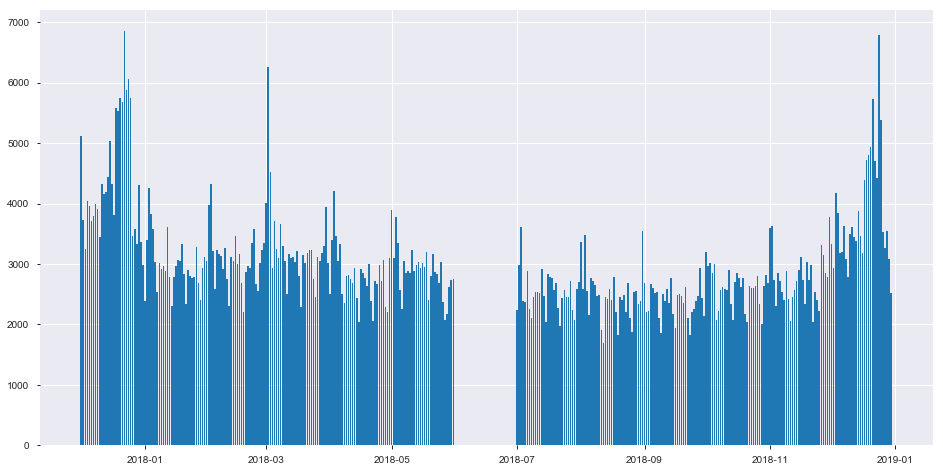

In [7]:
plt.figure(figsize=(16, 8))
df_dt_count = whole['date_'].value_counts().reset_index().rename(columns={'index': 'date_', 'date_': 'count_'}).sort_values(by='date_')
plt.bar(df_dt_count['date_'].values, df_dt_count['count_'].values)

<BarContainer object of 182 artists>

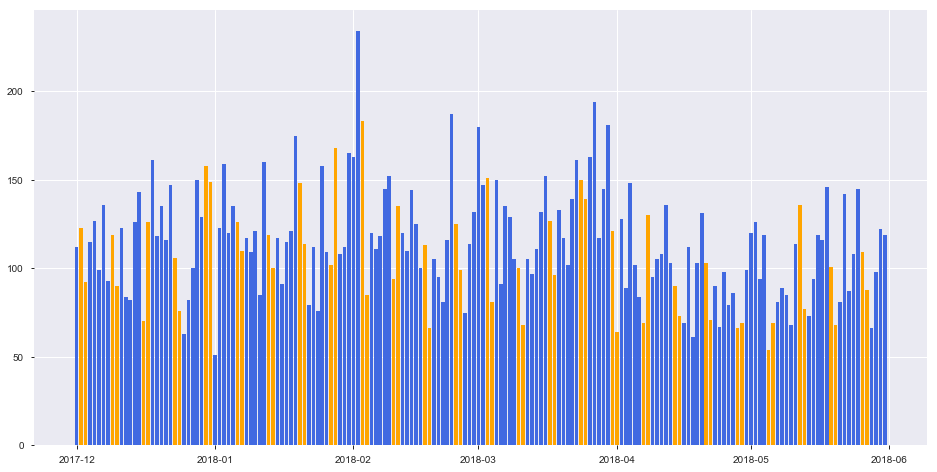

In [8]:
START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
whole = df_train_transaction[df_train_transaction['isFraud'] == 1][['TransactionDT']].reset_index(drop=True)
whole['datetime_'] = whole['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
whole['date_'] = whole['datetime_'].apply(lambda x: x.date())
# whole['month'] = whole['date_'] = whole['datetime_'].apply(lambda x: x.month)

df_dt_count = whole['date_'].value_counts().reset_index().rename(columns={'index': 'date_', 'date_': 'count_'}).sort_values(by='date_')
df_dt_count['weekday'] = df_dt_count['date_'].apply(lambda x: x.weekday())

colorlist = ["b", "r"]
df_dt_count['color'] = df_dt_count['weekday'].apply(lambda x: "royalblue" if x < 5 else "orange")

plt.figure(figsize=(16, 8))
plt.bar(df_dt_count['date_'].values, df_dt_count['count_'].values, color=df_dt_count['color'])

### TransactionAmt

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


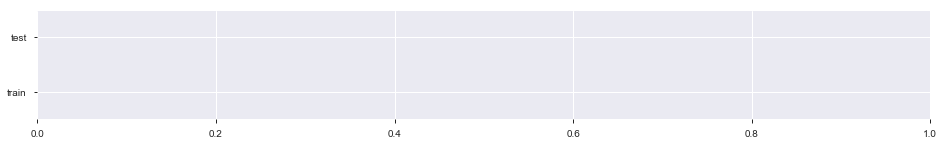

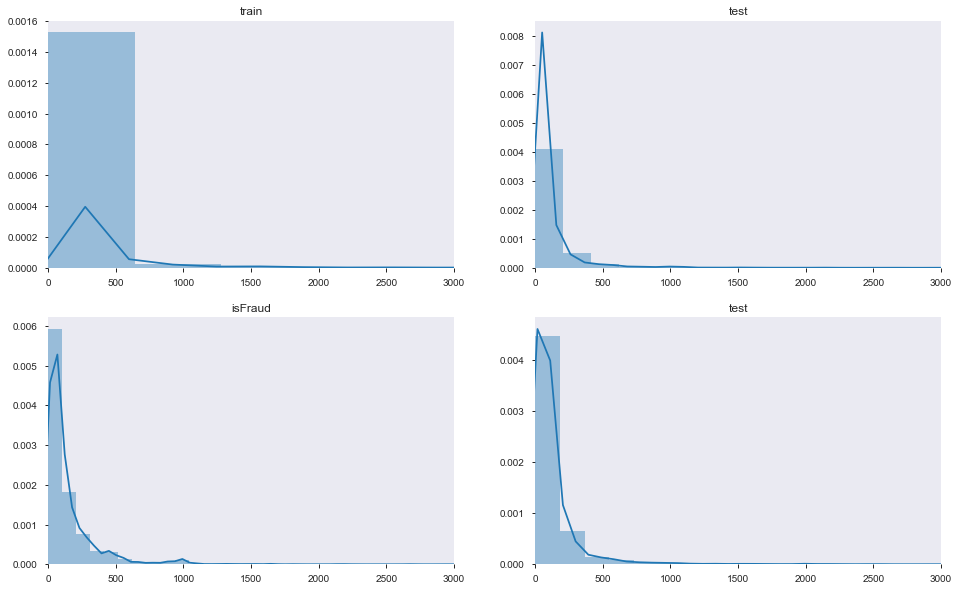

In [9]:
# drop_idx = [274336, 274339]
# whole = concat(df_train_transaction.drop(drop_idx, axis=0), df_test_transaction, ['TransactionAmt'])
# print(whole['TransactionAmt'].describe())

null_rate_plot('TransactionAmt')

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
sns.distplot(df_train_transaction['TransactionAmt'].values)
plt.xlim([0, 3000])
plt.title('train')
plt.grid()

plt.subplot(2, 2, 2)
sns.distplot(df_test_transaction['TransactionAmt'].values)
plt.xlim([0, 3000])
plt.title('test')
plt.grid()


plt.subplot(2, 2, 3)
sns.distplot(df_train_transaction[df_train_transaction['isFraud'] == 1]['TransactionAmt'].values)
plt.xlim([0, 3000])
plt.title('isFraud')
plt.grid()

plt.subplot(2, 2, 4)
sns.distplot(df_test_transaction['TransactionAmt'].iloc[:int(len(df_test_transaction) * 0.2)].values)
plt.xlim([0, 3000])
plt.title('test')
plt.grid()

### ProductCD

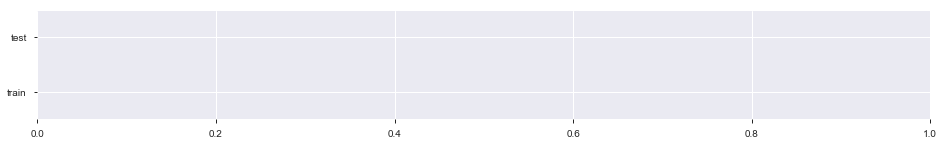

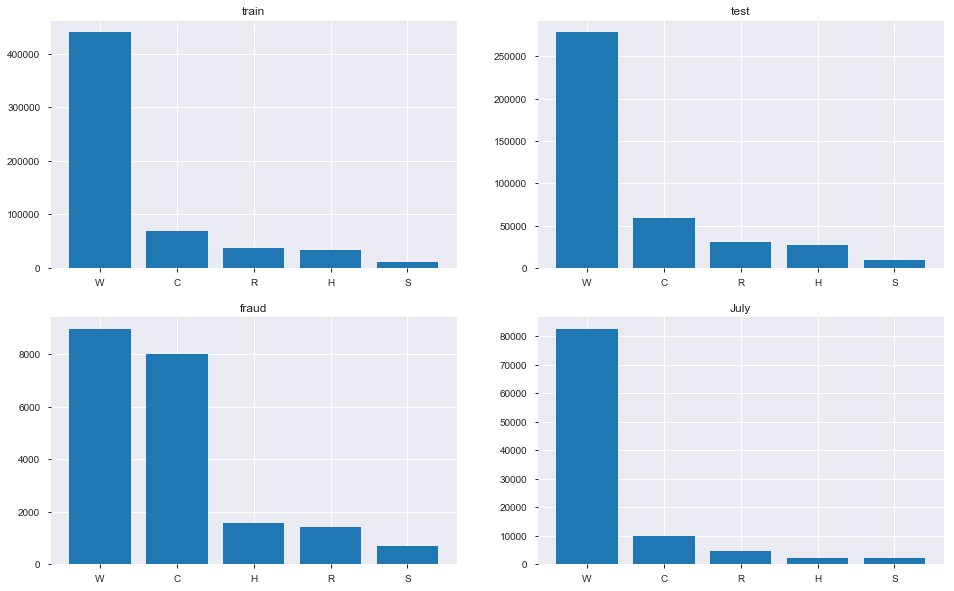

In [10]:
plot('ProductCD')

# Card系
---

### card1
カードID？ もしくは企業？

train unique_num:  13553
test unique_num:  13244


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


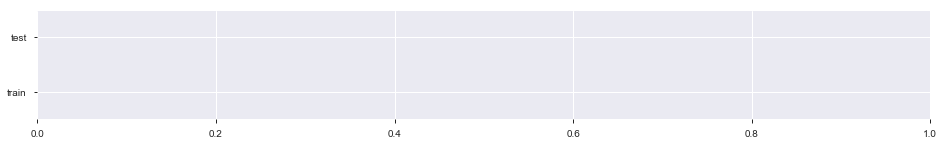

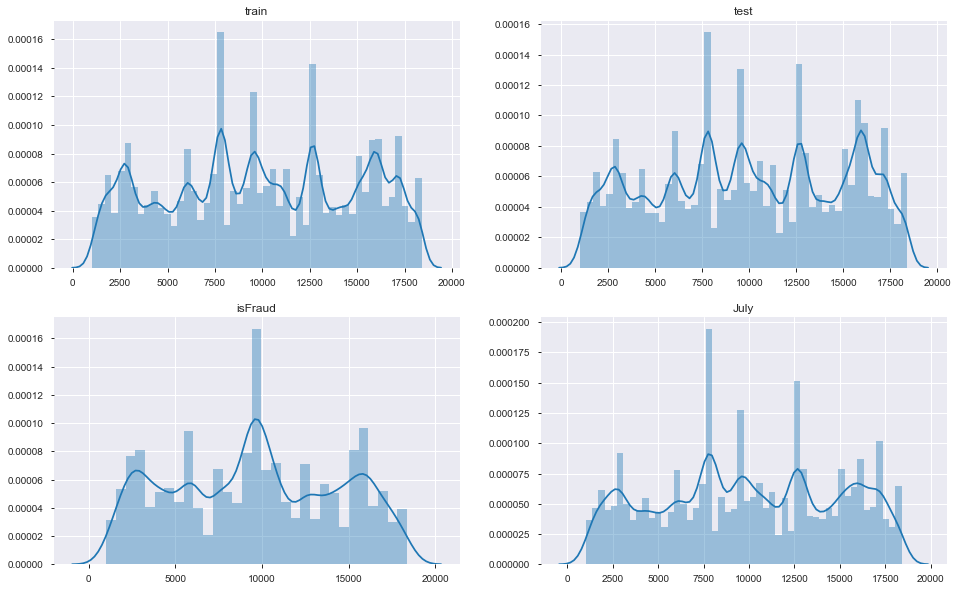

In [11]:
plot('card1')

### card2
銀行らしい

train unique_num:  501
test unique_num:  498


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


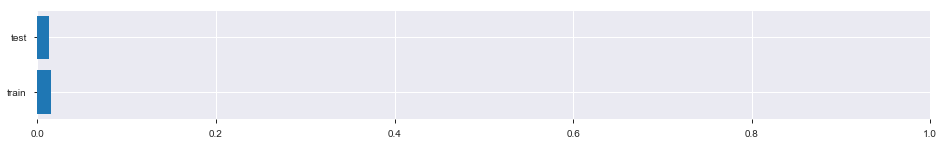

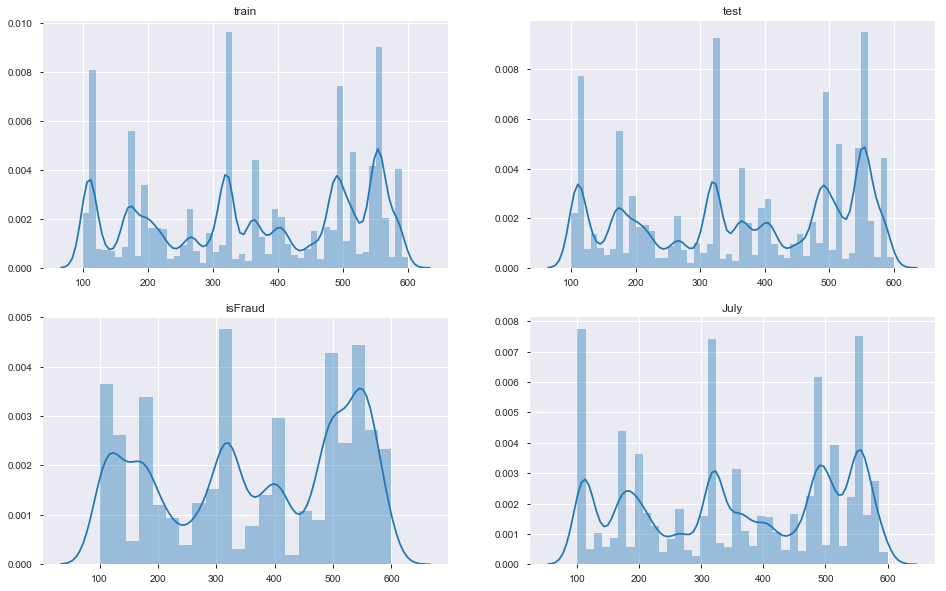

In [12]:
plot('card2')

### card3

train unique_num:  115
test unique_num:  116


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


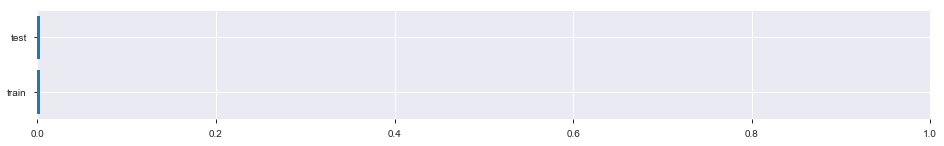

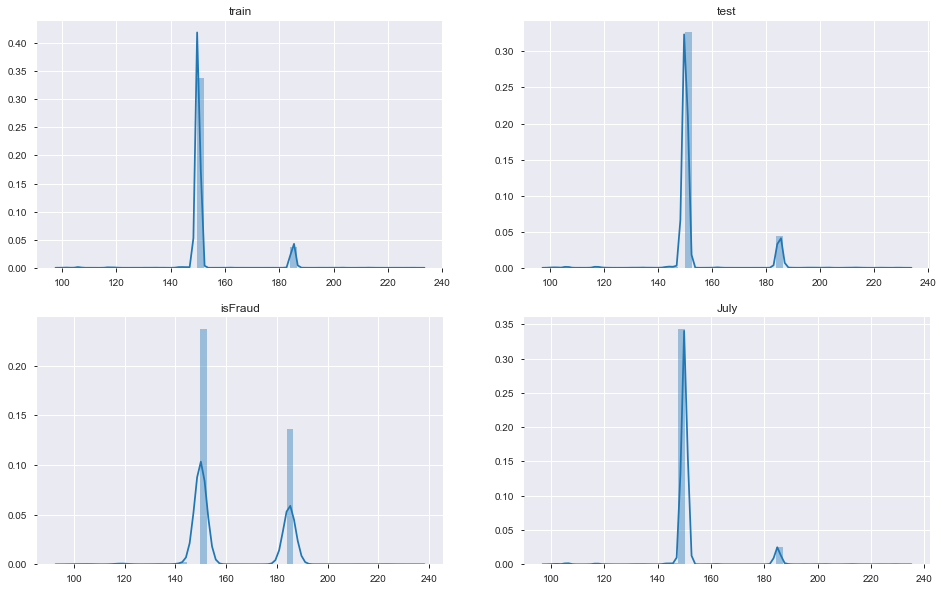

In [13]:
plot('card3')

### card4

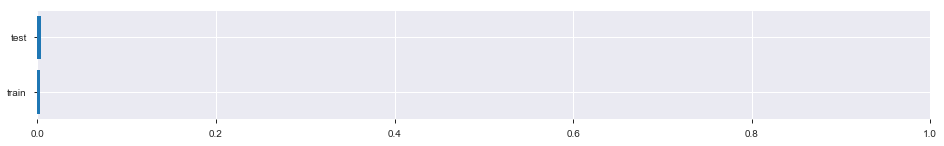

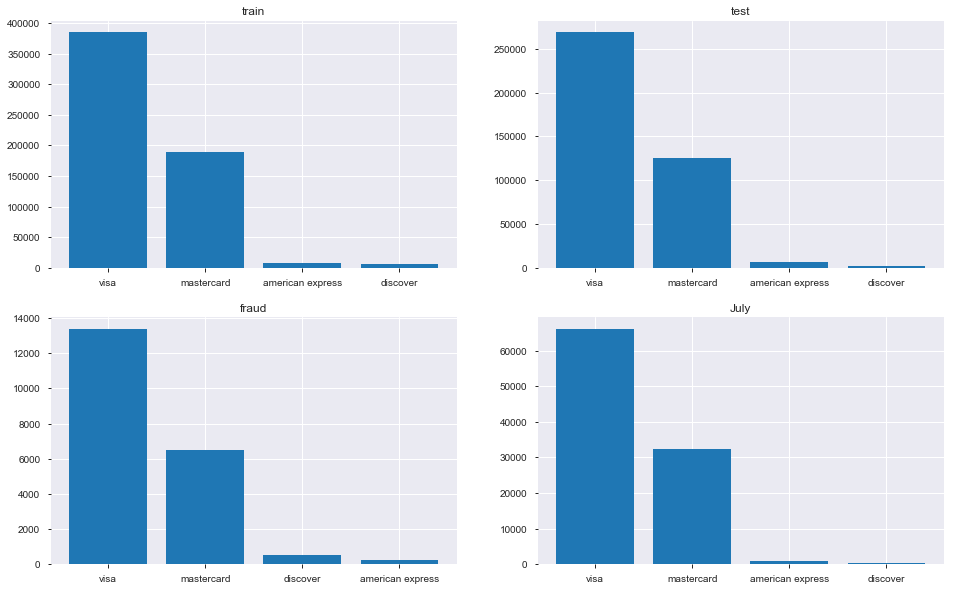

In [14]:
plot('card4')

### card5

train unique_num:  120
test unique_num:  103


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


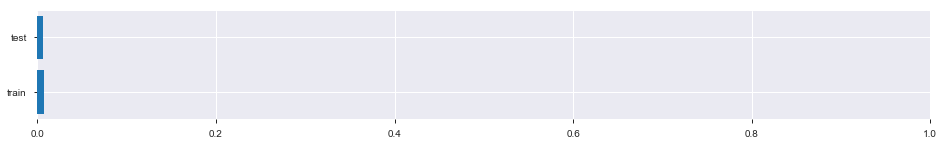

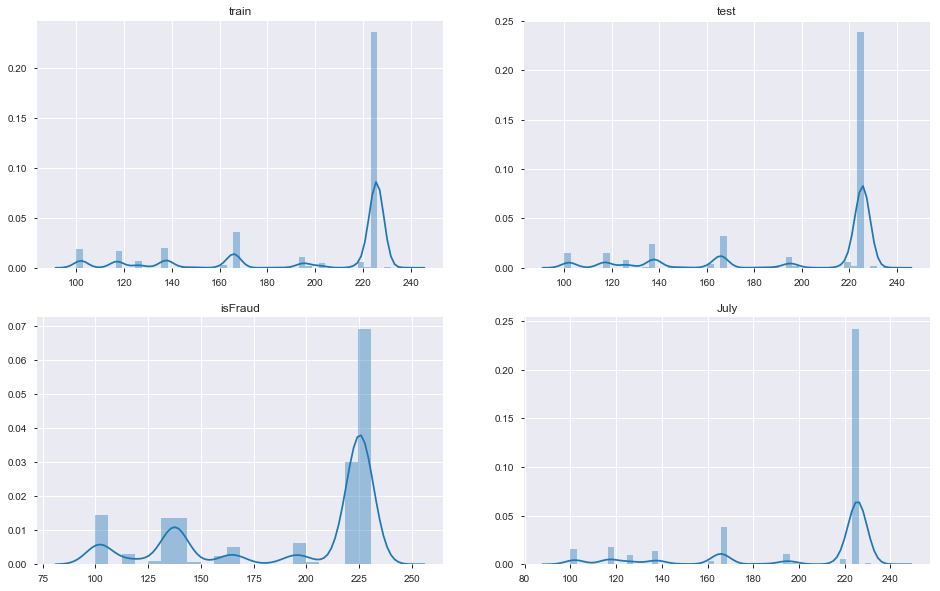

In [15]:
plot('card5')

### card6

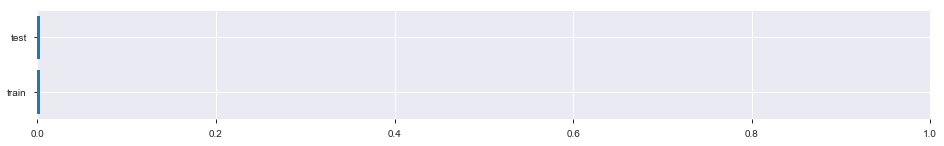

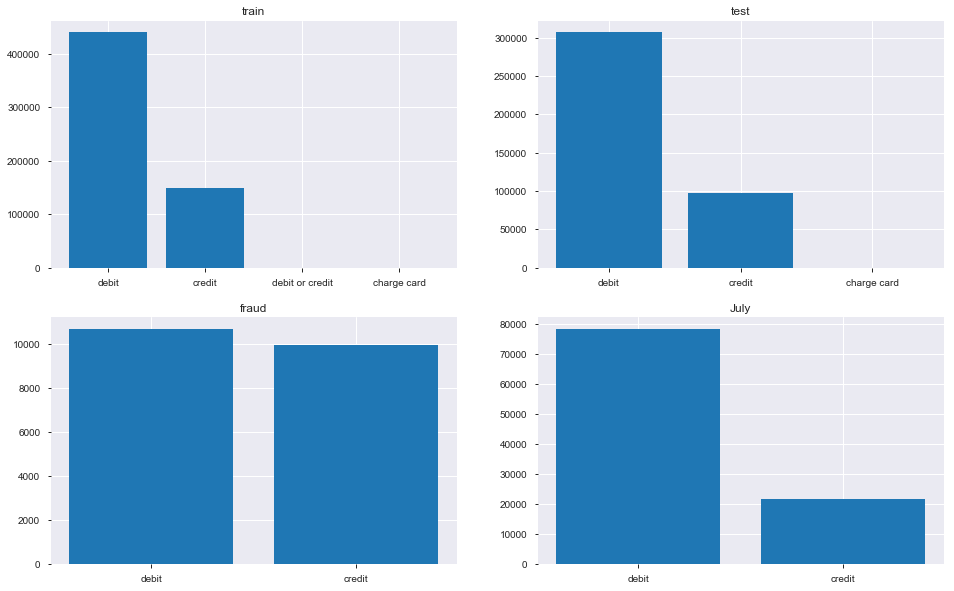

In [16]:
plot('card6')

# Addr系
---

### addr1
請求先の所在地域

train unique_num:  333
test unique_num:  293


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


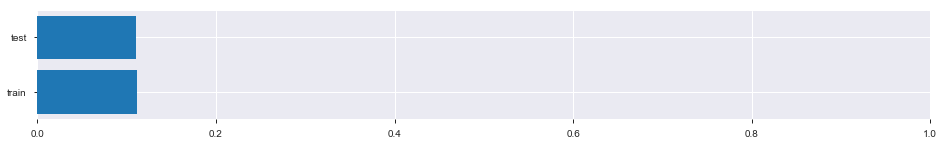

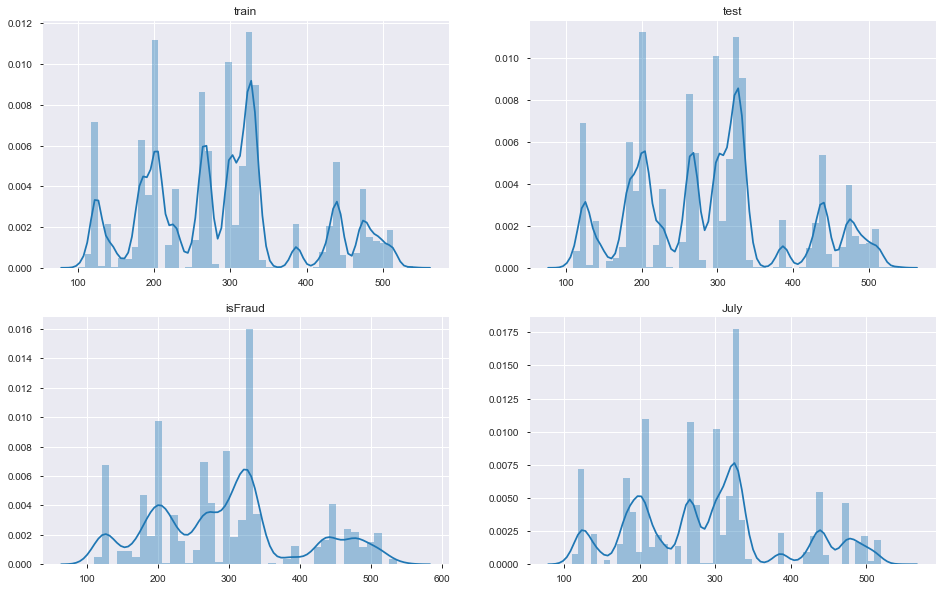

In [17]:
plot('addr1')

### addr2
請求先の所在国

train unique_num:  75
test unique_num:  73


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


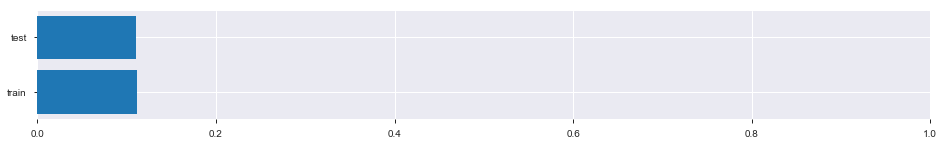

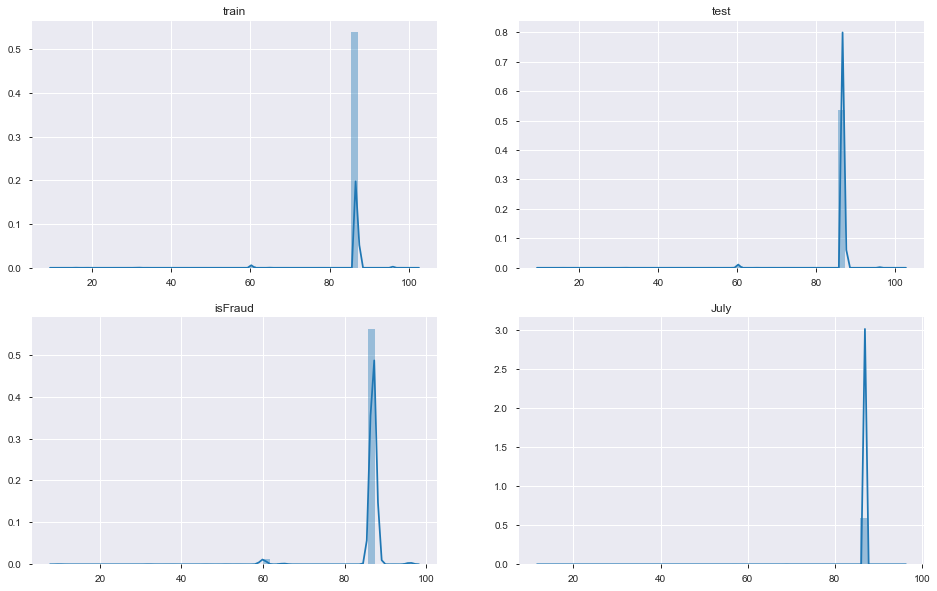

In [18]:
plot('addr2')

# dist系
---

### dist1

train unique_num:  2652
test unique_num:  1989


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


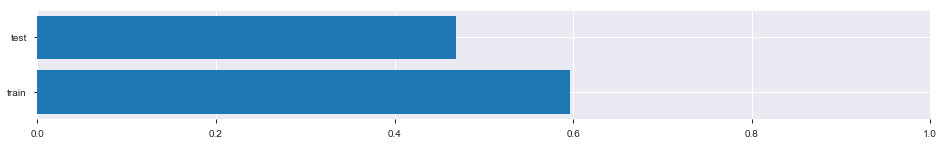

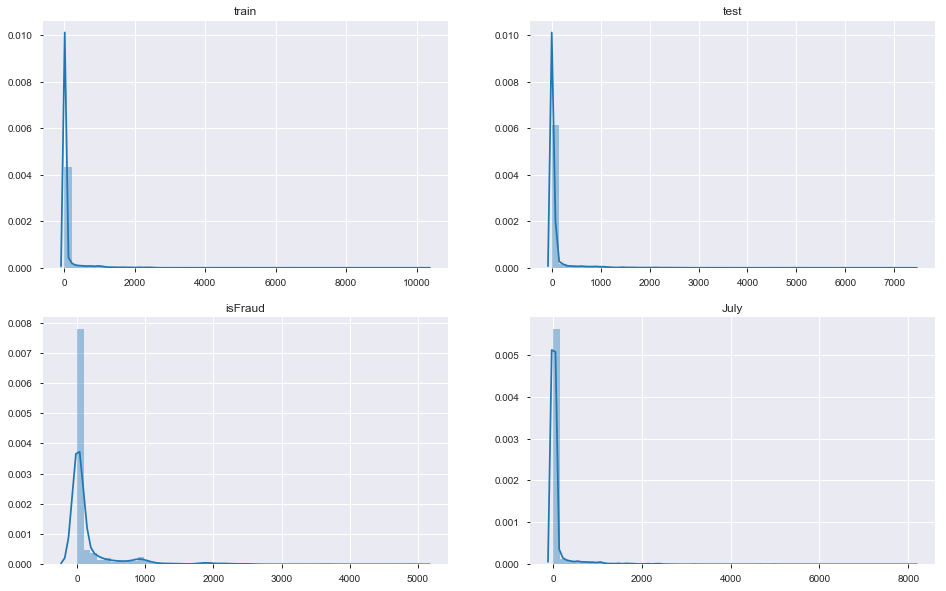

In [19]:
plot('dist1')

### dist2

train unique_num:  1752
test unique_num:  1815


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


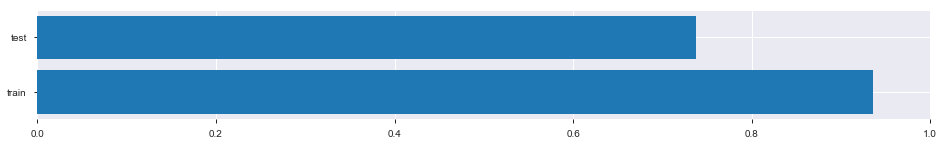

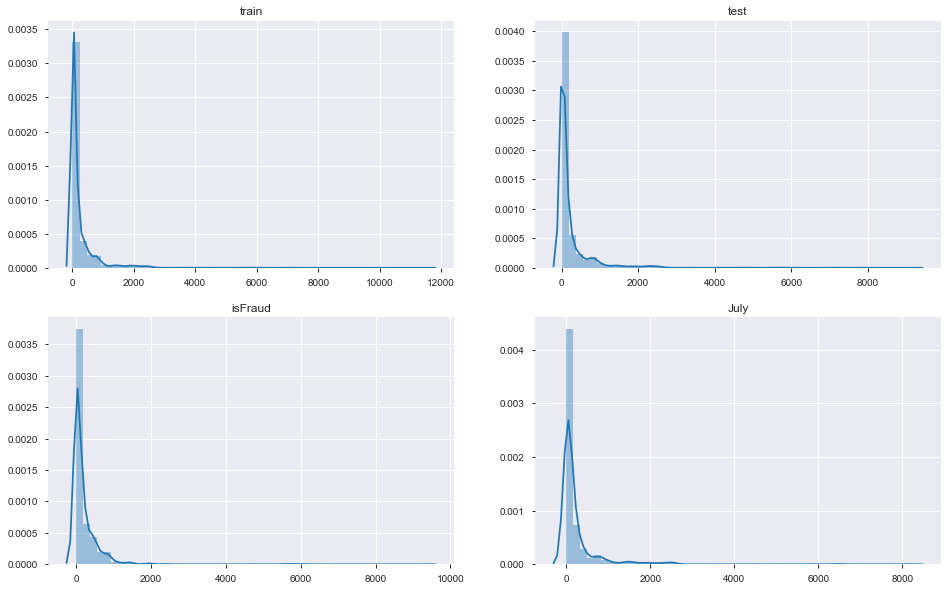

In [20]:
plot('dist2')

# emaildomain系
---

### P_emaildomain

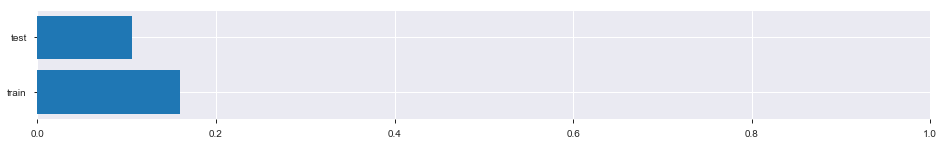

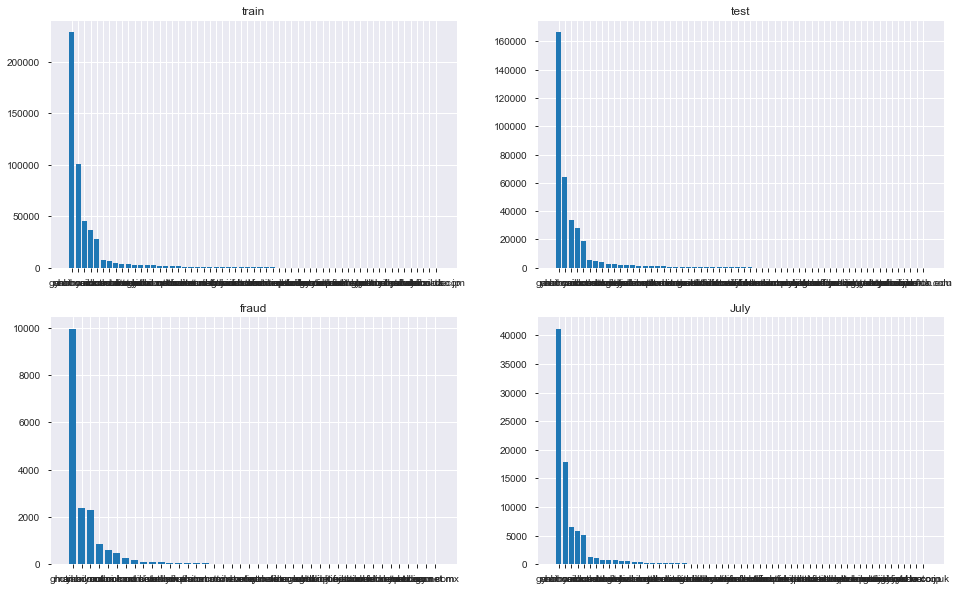

In [21]:
plot('P_emaildomain')

### R_emaildomain

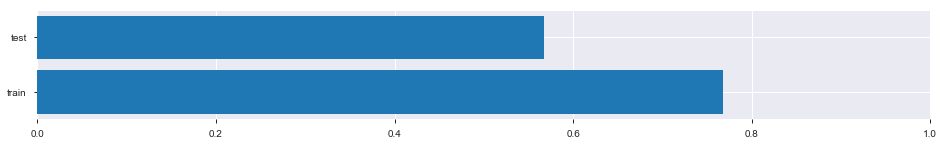

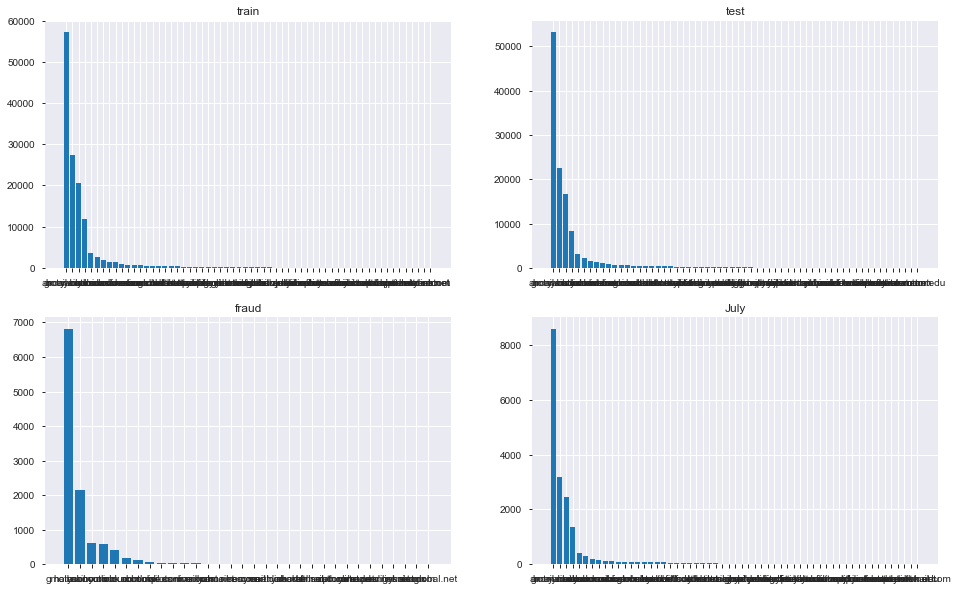

In [22]:
plot('R_emaildomain')

# C系
---
ユーザーに関するデータらしい

>“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15.

>Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”


### C1

train unique_num:  1657
test unique_num:  1175


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


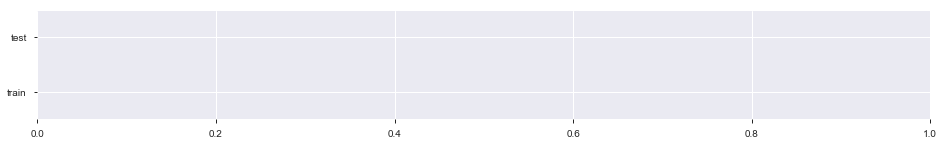

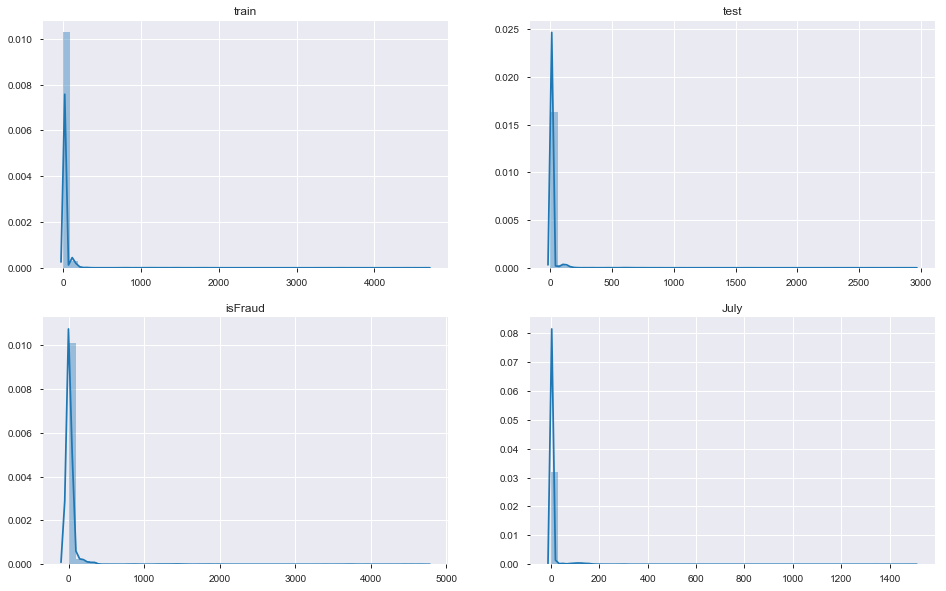

In [23]:
plot('C1')

### C2

train unique_num:  1216
test unique_num:  1124


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


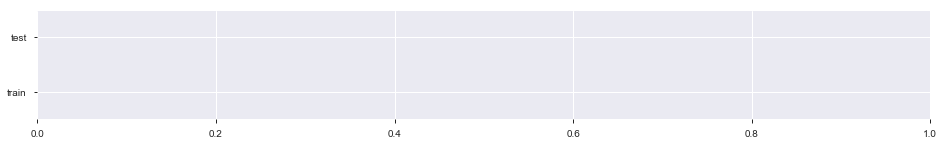

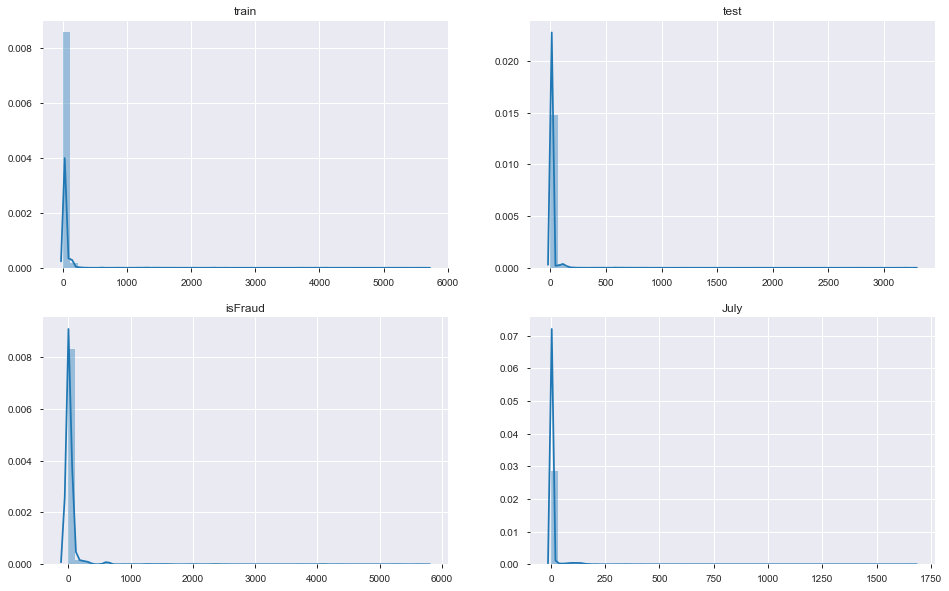

In [24]:
plot('C2')

### C3

train unique_num:  27
test unique_num:  32


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


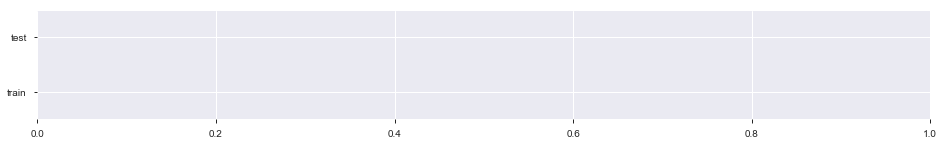

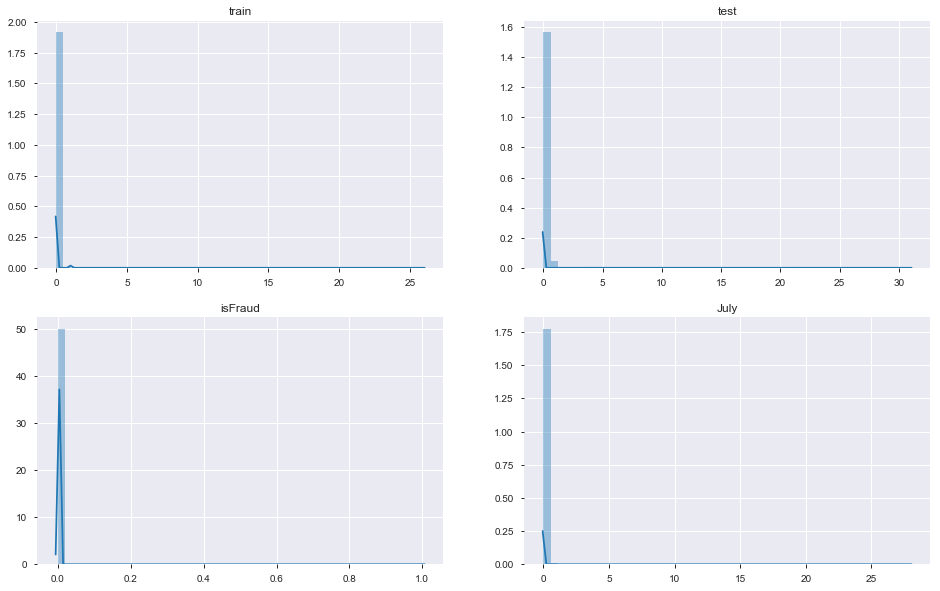

In [25]:
plot('C3')

### C4

train unique_num:  1260
test unique_num:  729


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


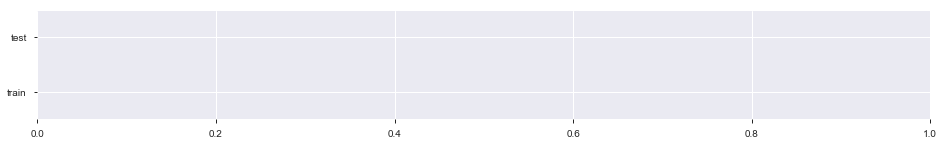

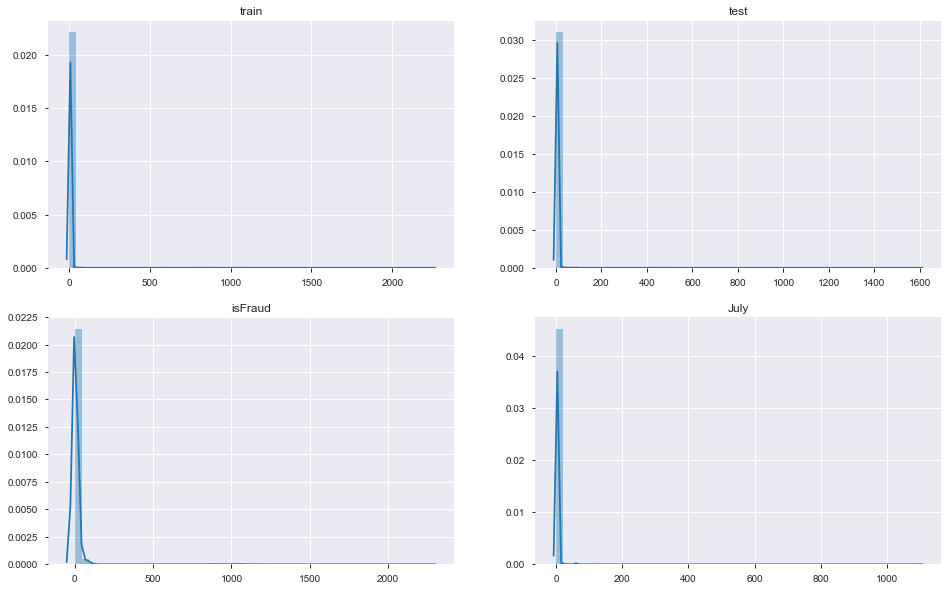

In [26]:
plot('C4')

### C5

train unique_num:  1260
test unique_num:  729


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


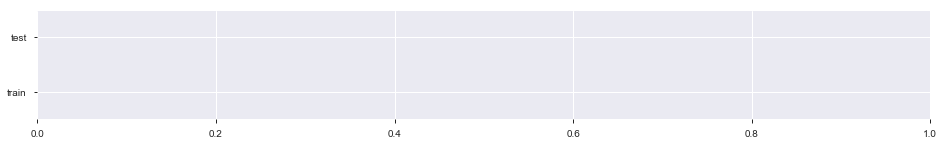

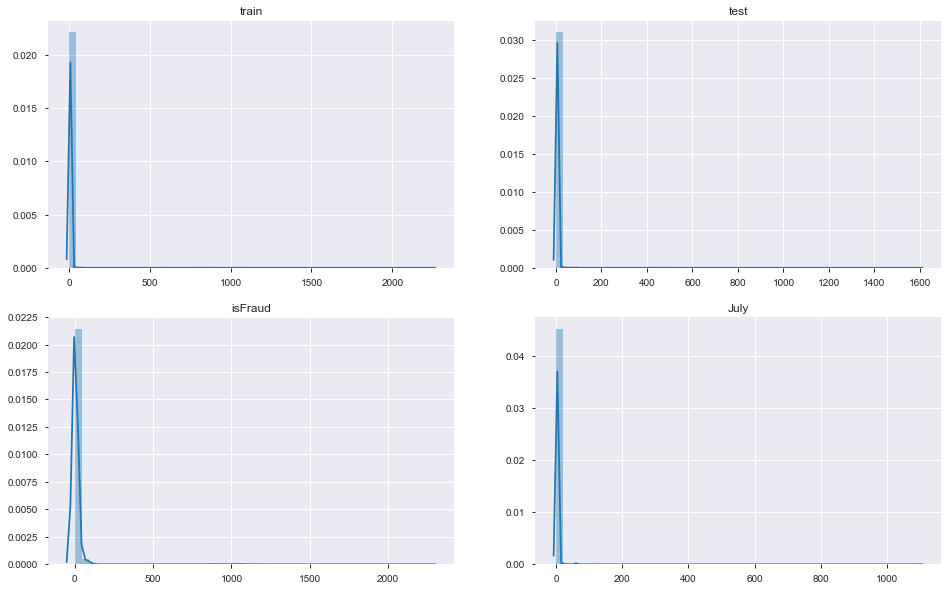

In [27]:
plot('C4')

### C6

train unique_num:  1328
test unique_num:  835


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


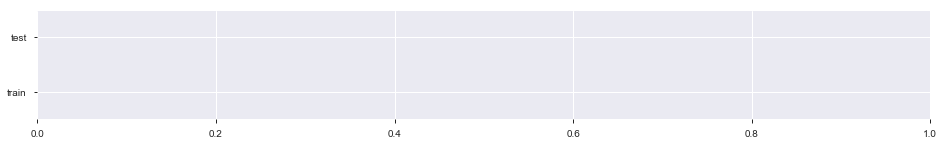

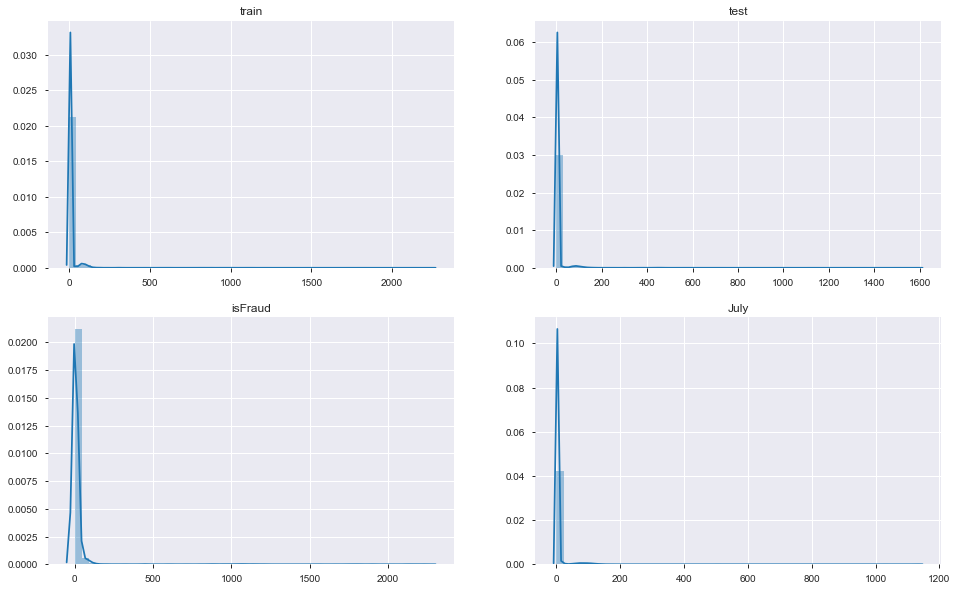

In [28]:
plot('C6')

### C7

train unique_num:  1103
test unique_num:  519


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


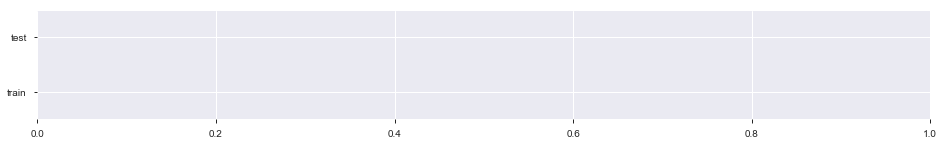

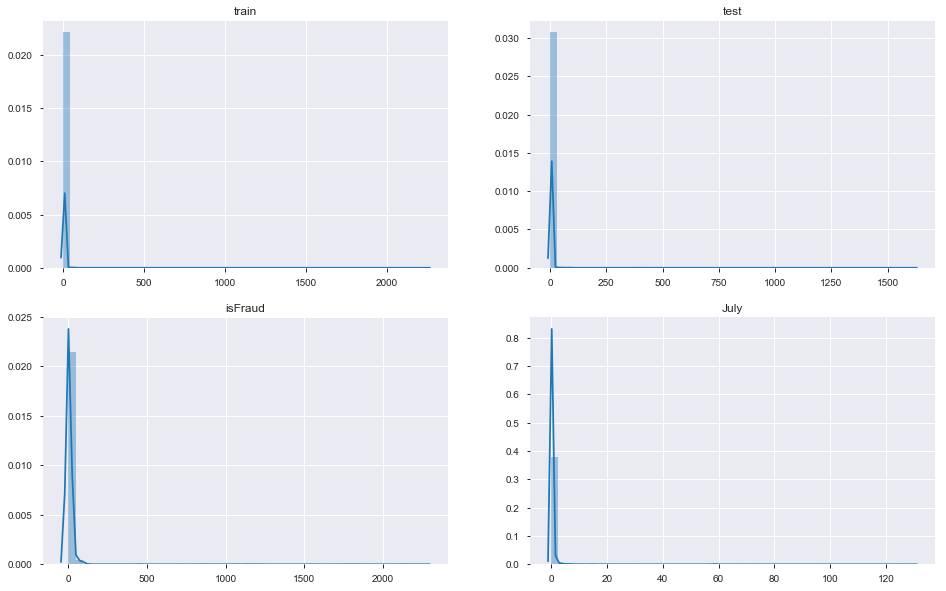

In [29]:
plot('C7')

### C8

train unique_num:  1253
test unique_num:  443


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


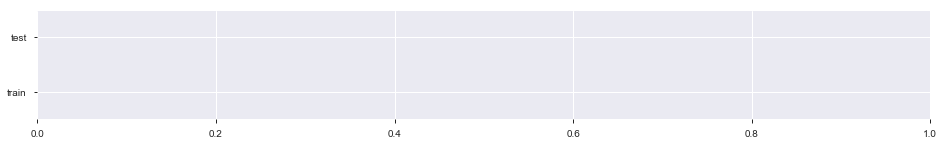

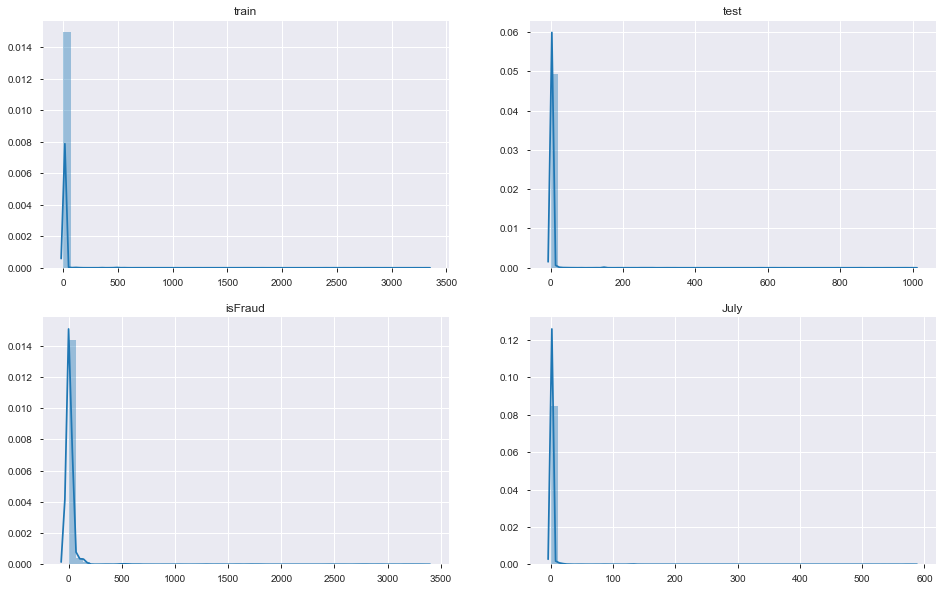

In [30]:
plot('C8')

### C9

train unique_num:  205
test unique_num:  355


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


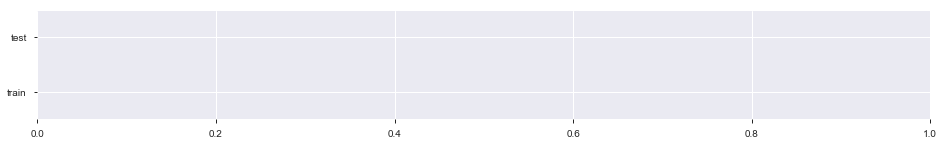

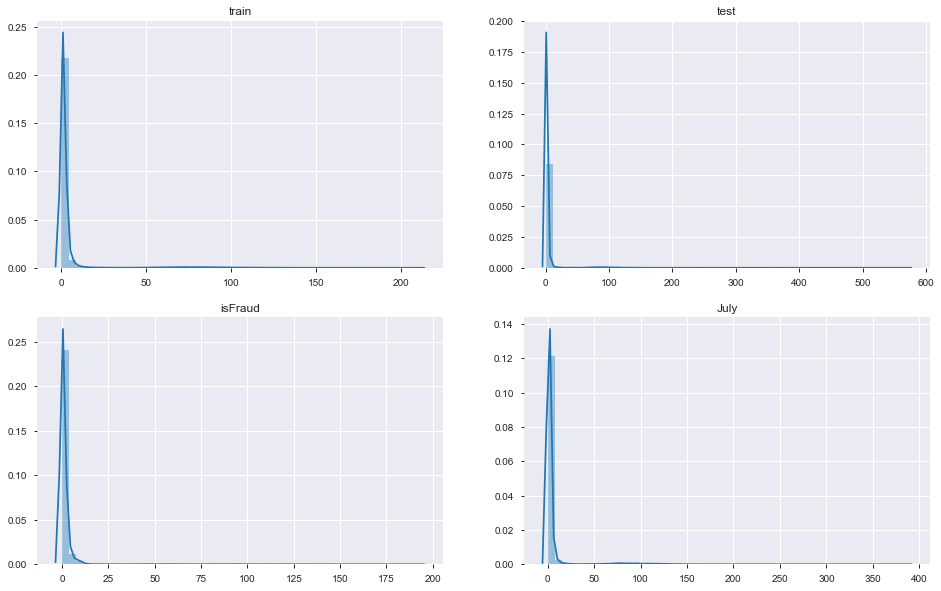

In [31]:
plot('C9')

### C10

train unique_num:  1231
test unique_num:  457


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


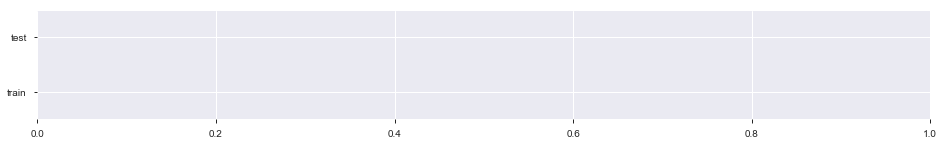

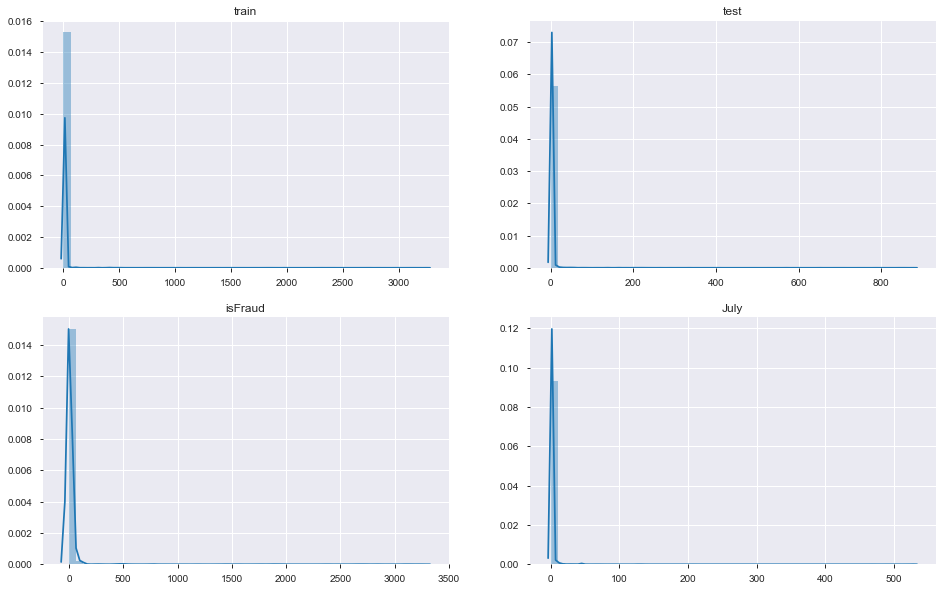

In [32]:
plot('C10')

### C11

train unique_num:  1476
test unique_num:  938


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


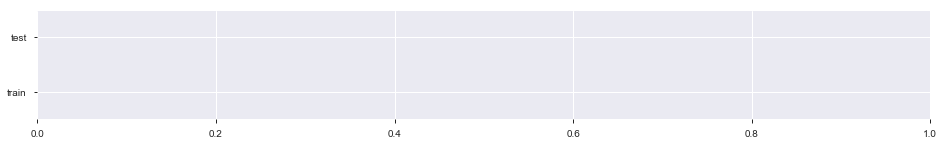

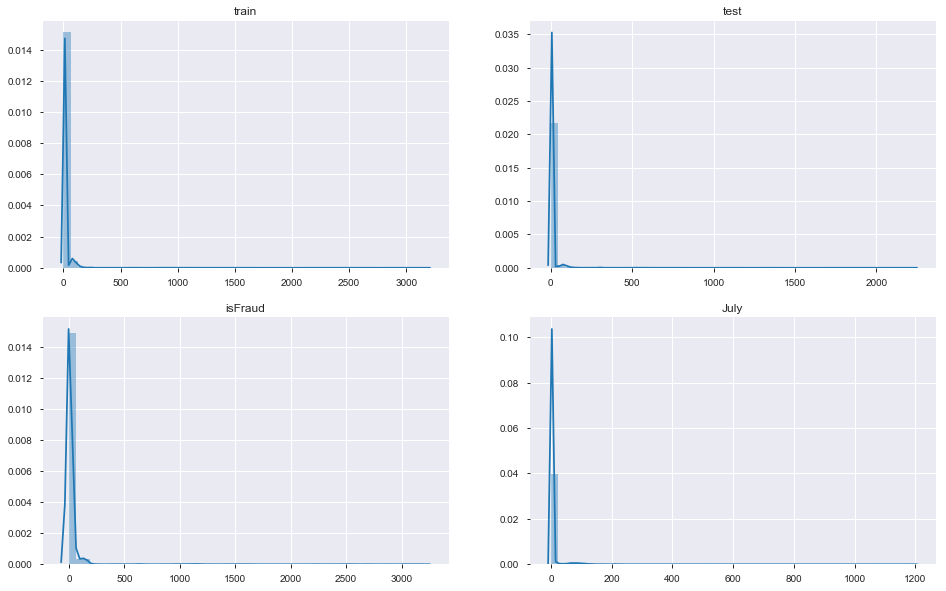

In [33]:
plot('C11')

### C12

train unique_num:  1199
test unique_num:  664


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


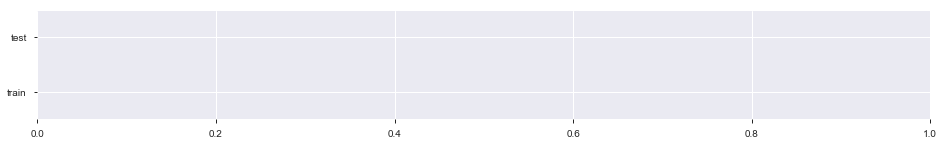

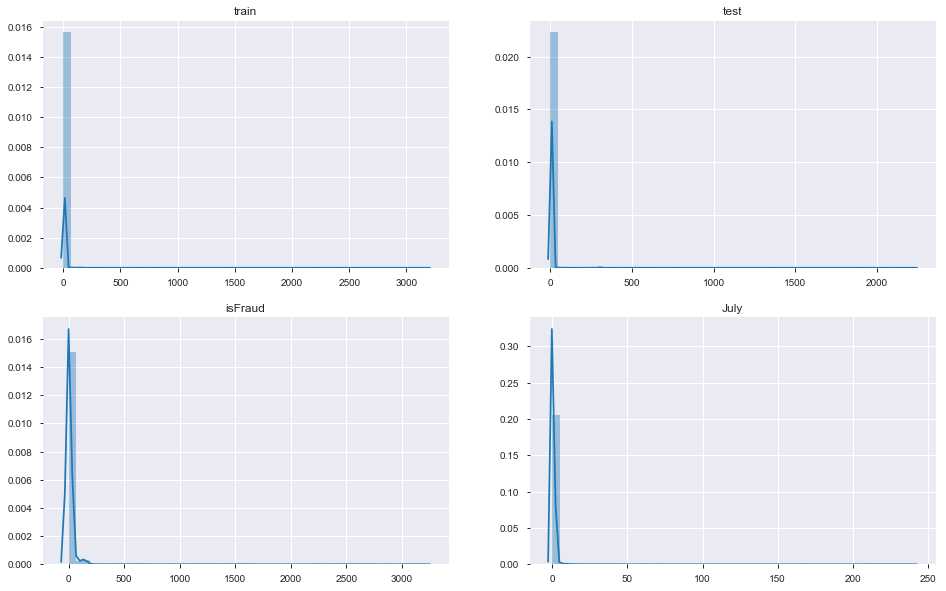

In [34]:
plot('C12')

### C13

train unique_num:  1597
test unique_num:  1070


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


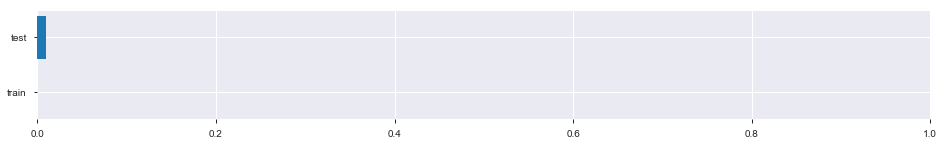

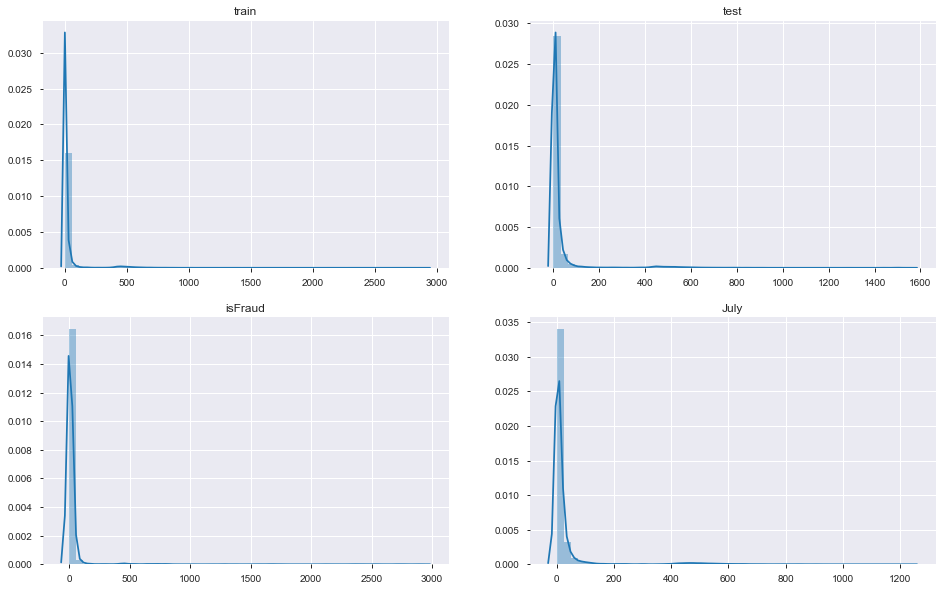

In [35]:
plot('C13')

### C14

train unique_num:  1108
test unique_num:  570


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


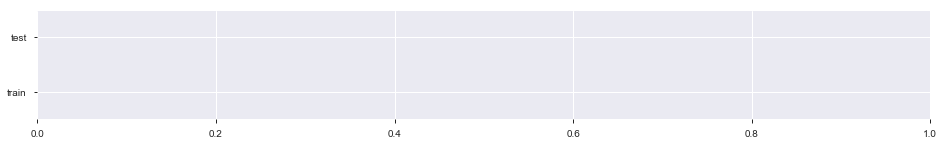

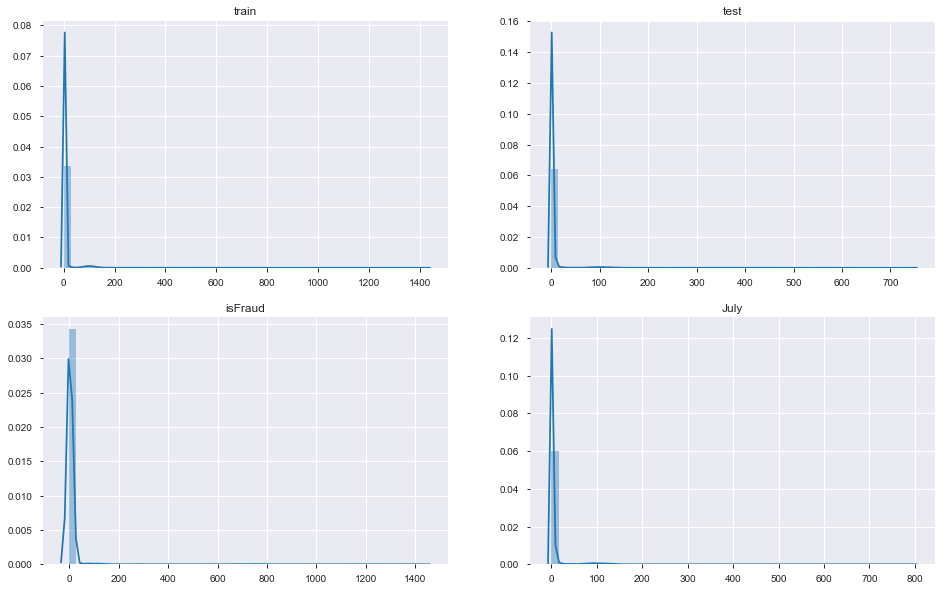

In [36]:
plot('C14')

# D系
---
過去のトランザクションに関するデータらしい

### D1
初回購入日からの経過日数？

train unique_num:  642
test unique_num:  643


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


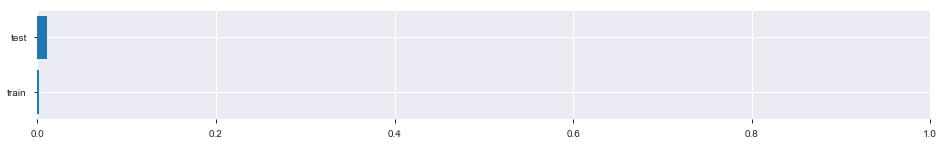

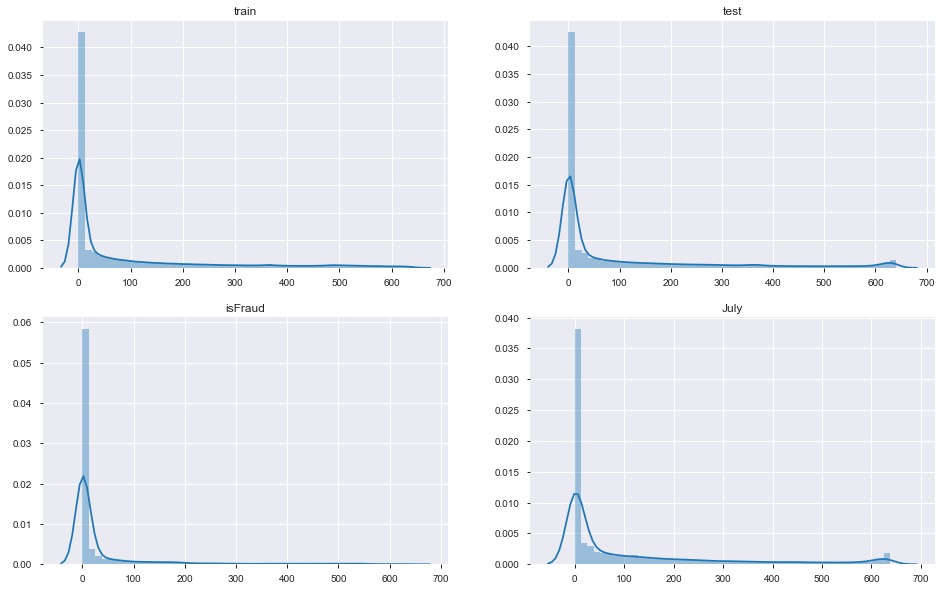

In [37]:
plot('D1')

### D2

train unique_num:  642
test unique_num:  643


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


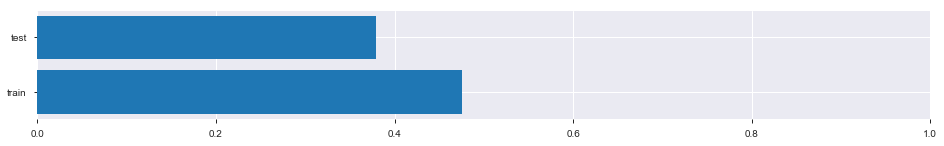

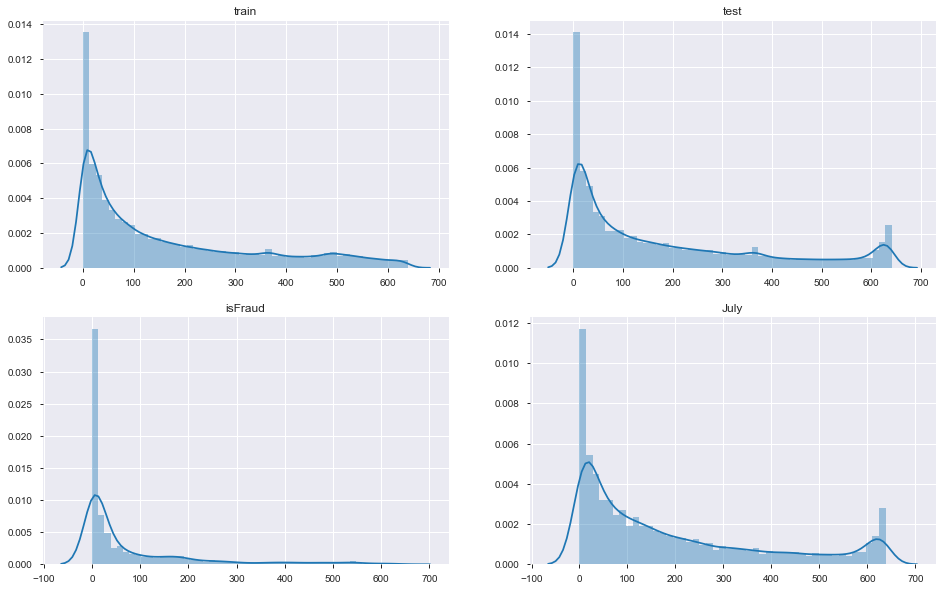

In [38]:
plot('D2')

### D3
前回購入日からの経過日数

train unique_num:  650
test unique_num:  888


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


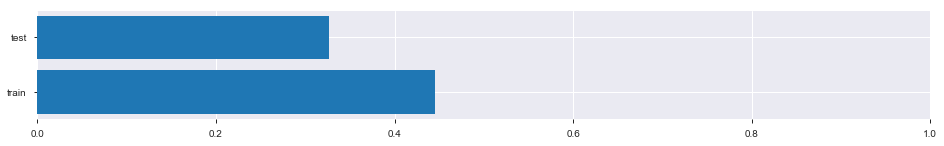

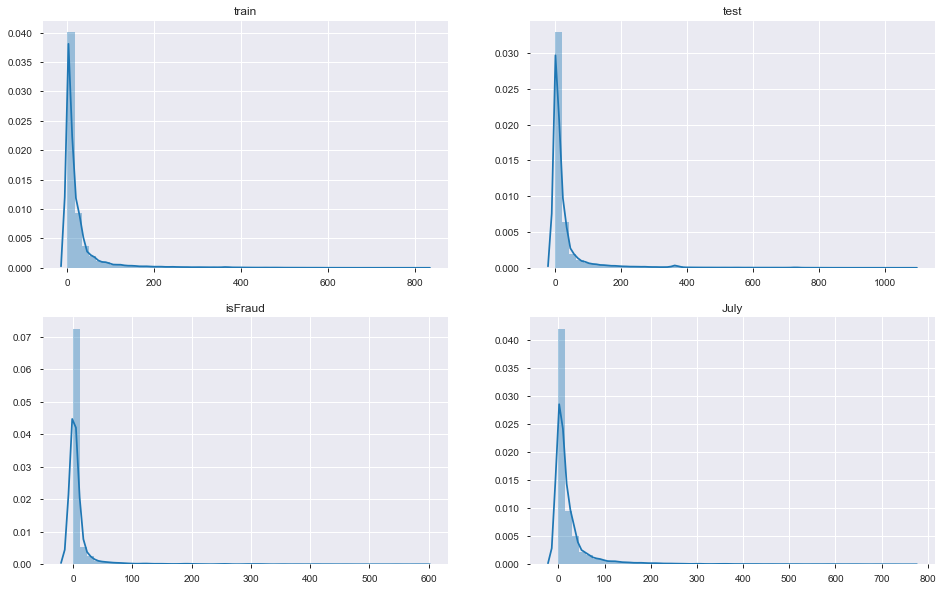

In [39]:
plot('D3')

### D4

train unique_num:  809
test unique_num:  1057


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


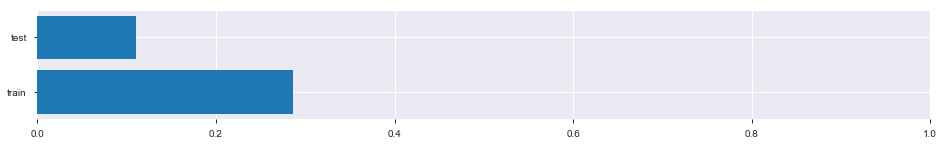

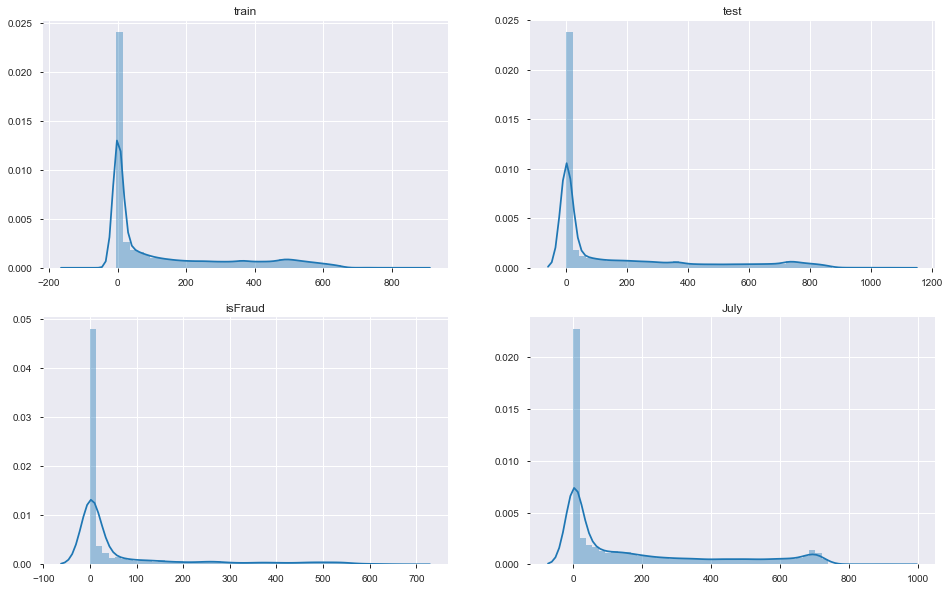

In [40]:
plot('D4')

### D5

train unique_num:  689
test unique_num:  962


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


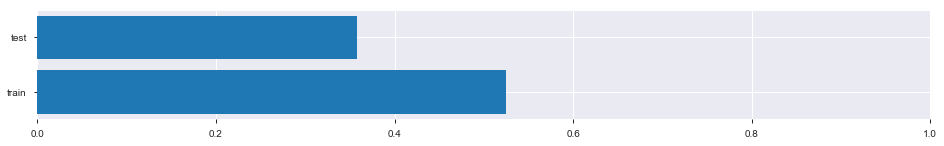

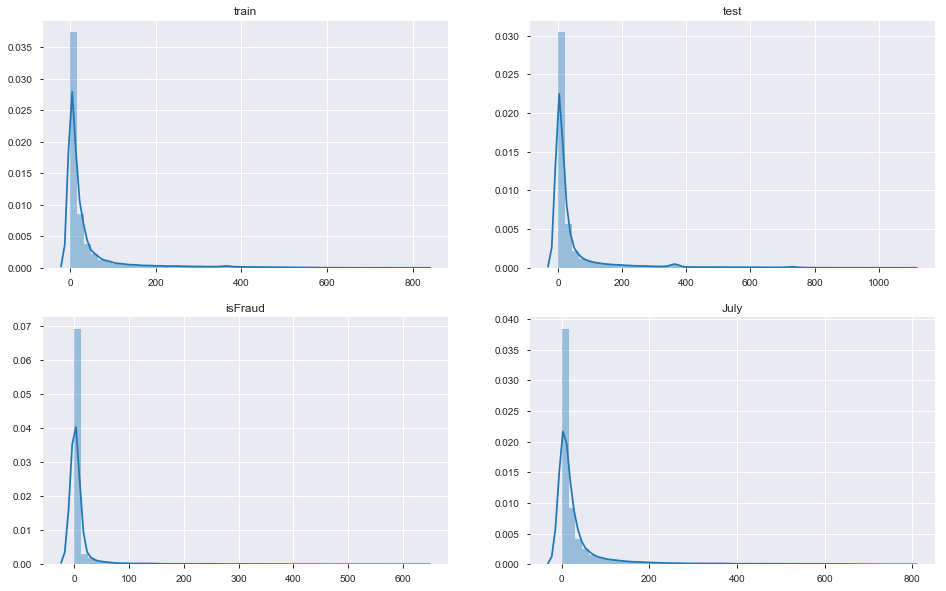

In [41]:
plot('D5')

### D6

train unique_num:  830
test unique_num:  1073


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


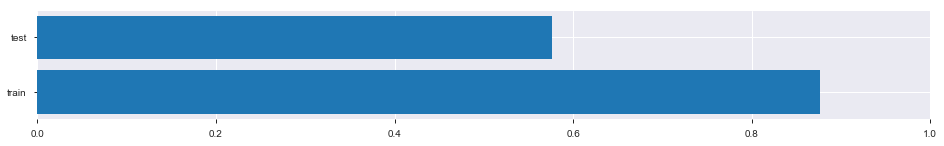

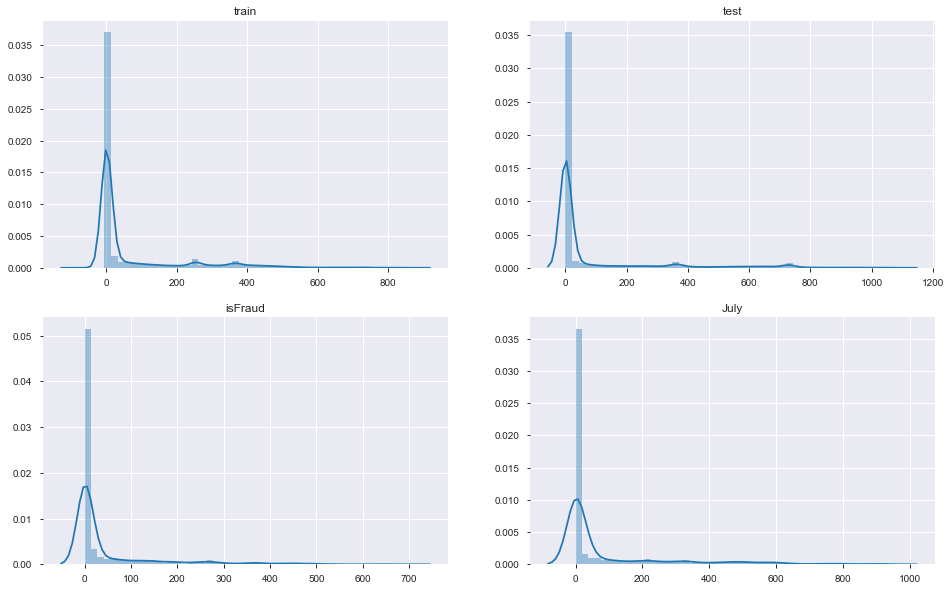

In [42]:
plot('D6')

### D7

train unique_num:  598
test unique_num:  905


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


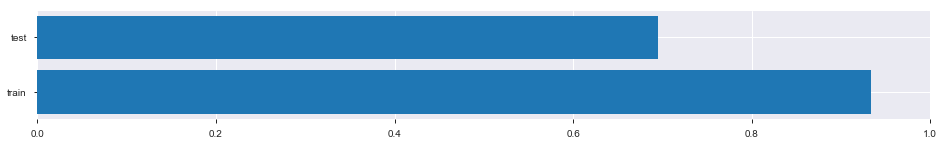

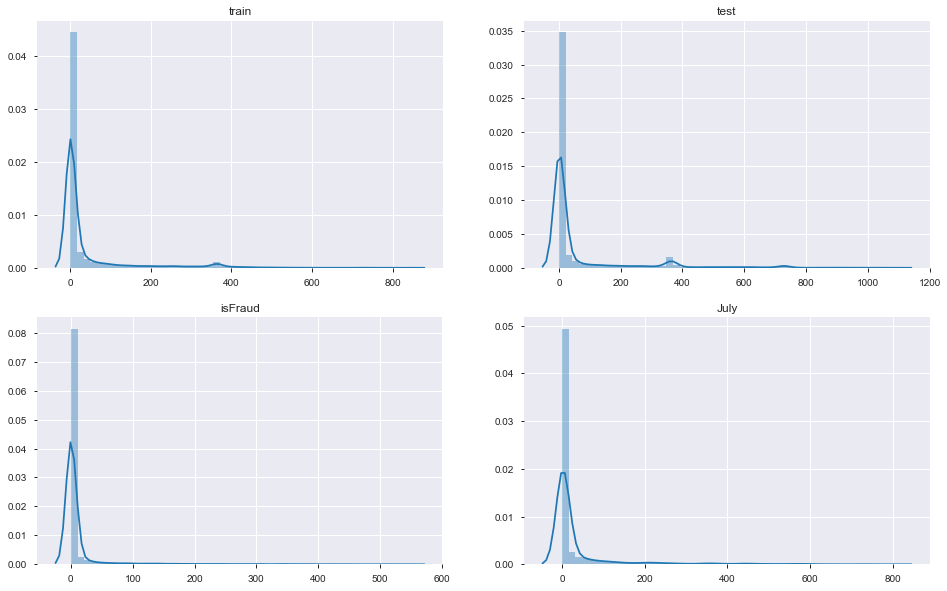

In [43]:
plot('D7')

### D8

train unique_num:  12354
test unique_num:  13245


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


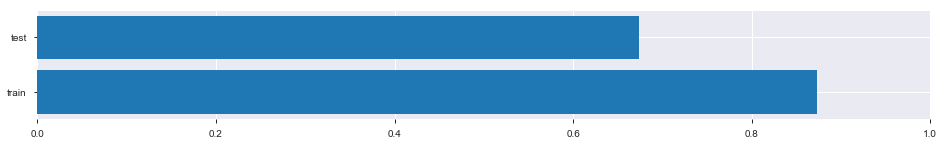

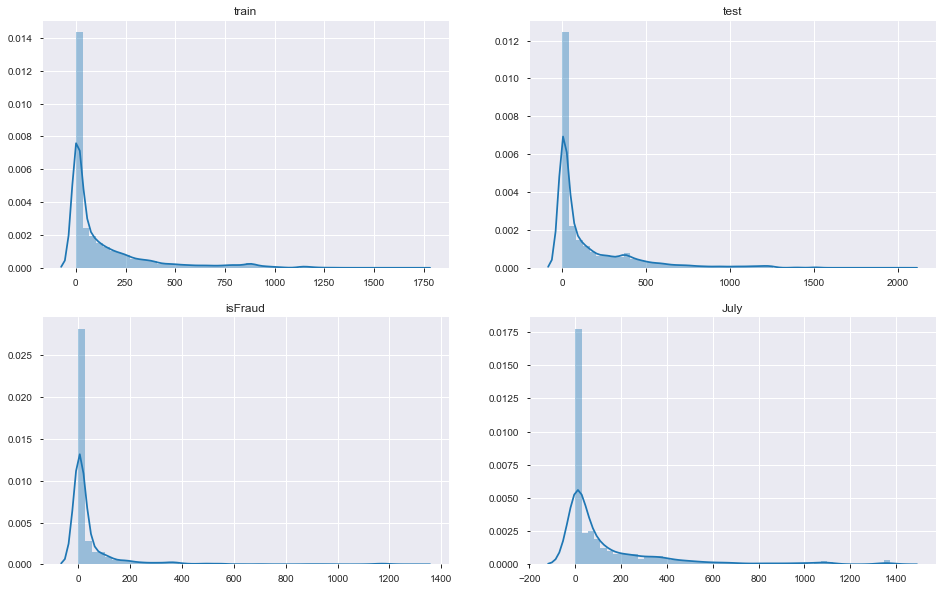

In [44]:
plot('D8')

### D9

train unique_num:  25
test unique_num:  25


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


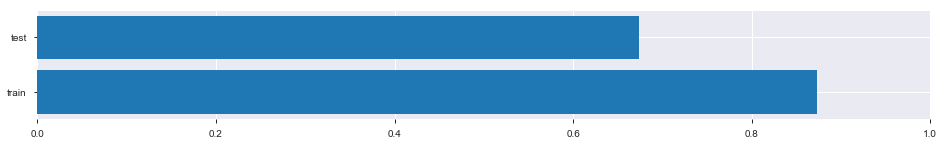

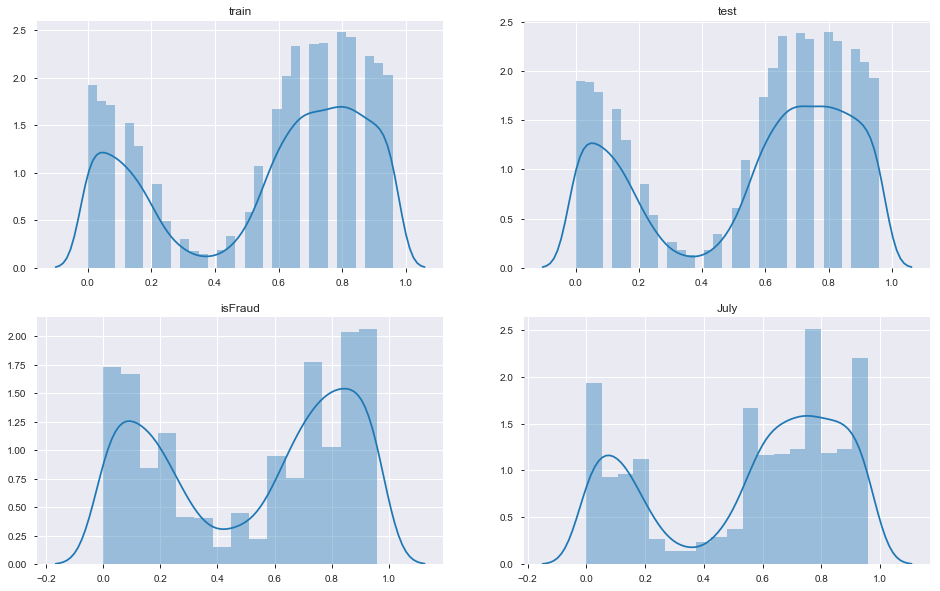

In [45]:
plot('D9')

### D10

train unique_num:  819
test unique_num:  1076


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


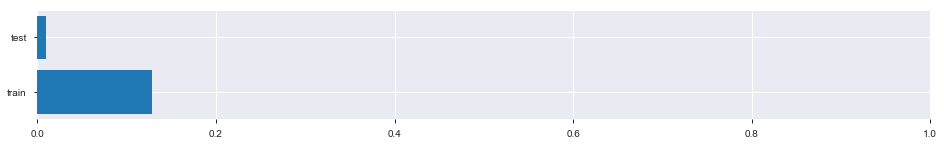

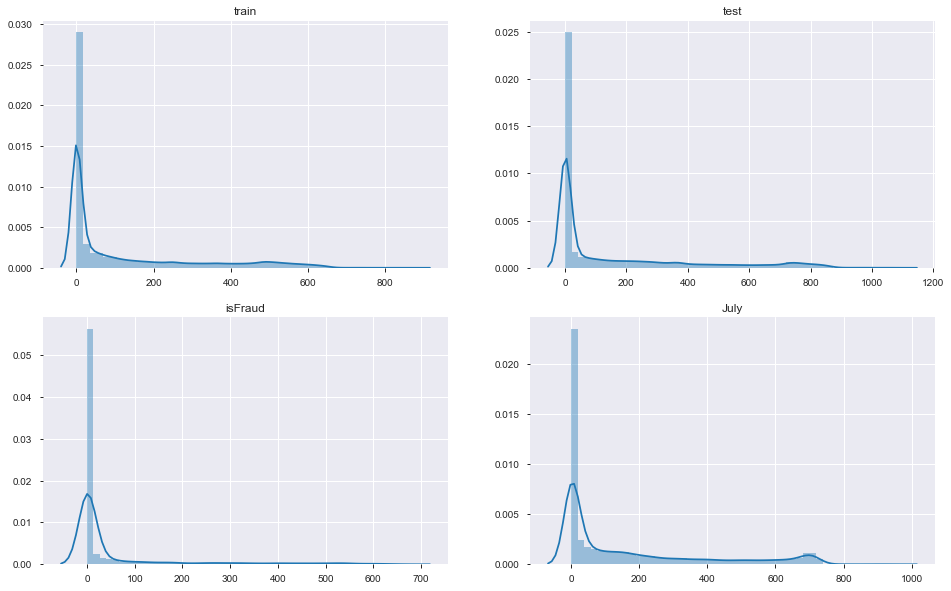

In [46]:
plot('D10')

### D11

train unique_num:  677
test unique_num:  881


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


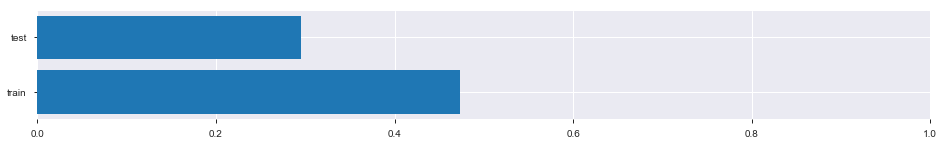

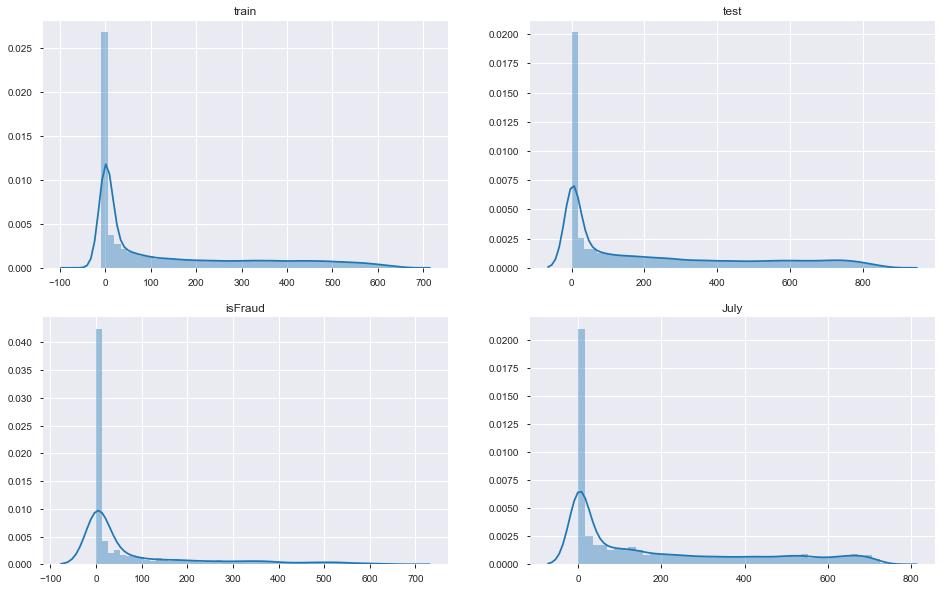

In [47]:
plot('D11')

### D12

train unique_num:  636
test unique_num:  867


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


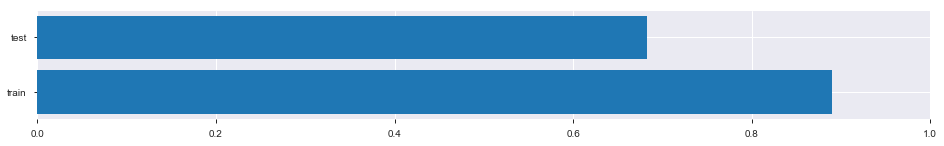

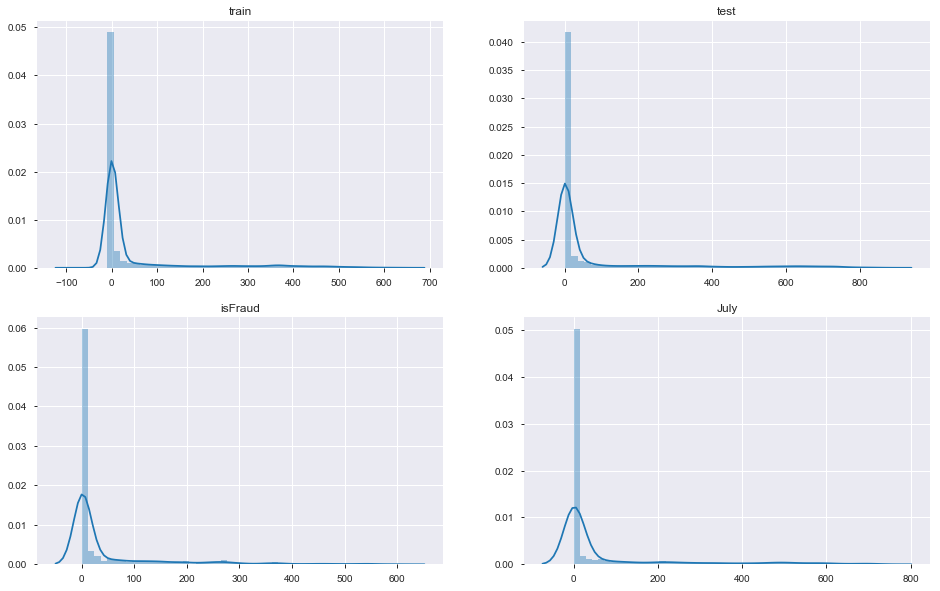

In [48]:
plot('D12')

### D13

train unique_num:  578
test unique_num:  806


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


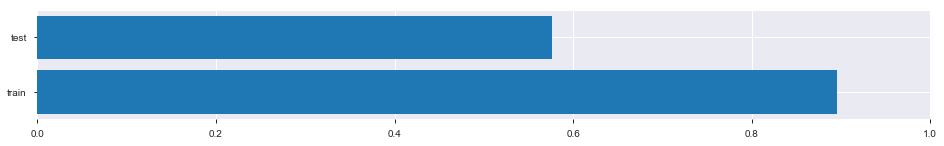

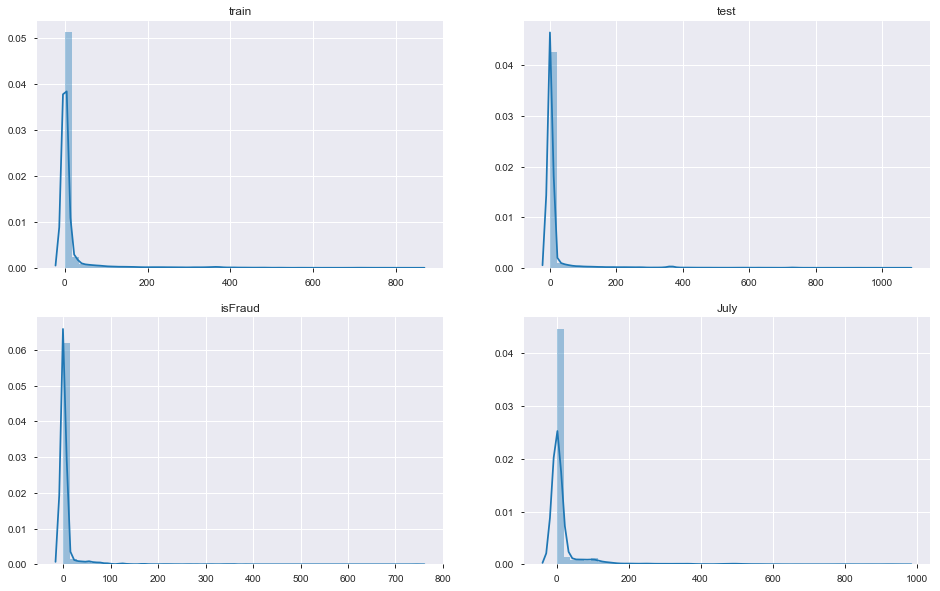

In [49]:
plot('D13')

### D14

train unique_num:  803
test unique_num:  1032


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


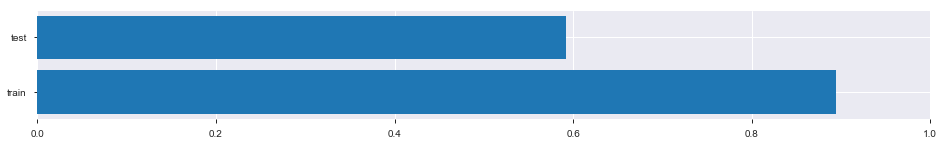

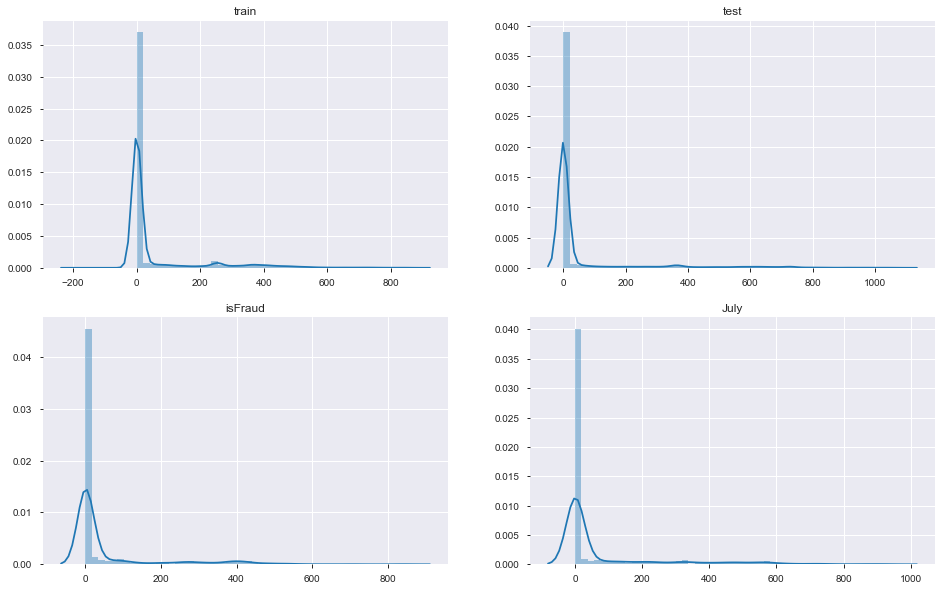

In [50]:
plot('D14')

### D15

train unique_num:  860
test unique_num:  1079


/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


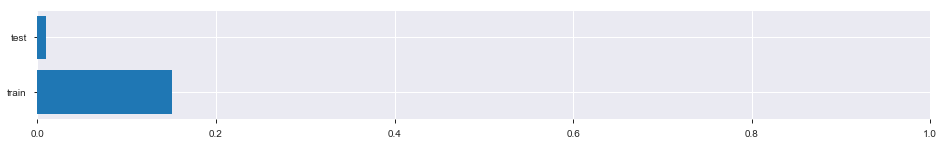

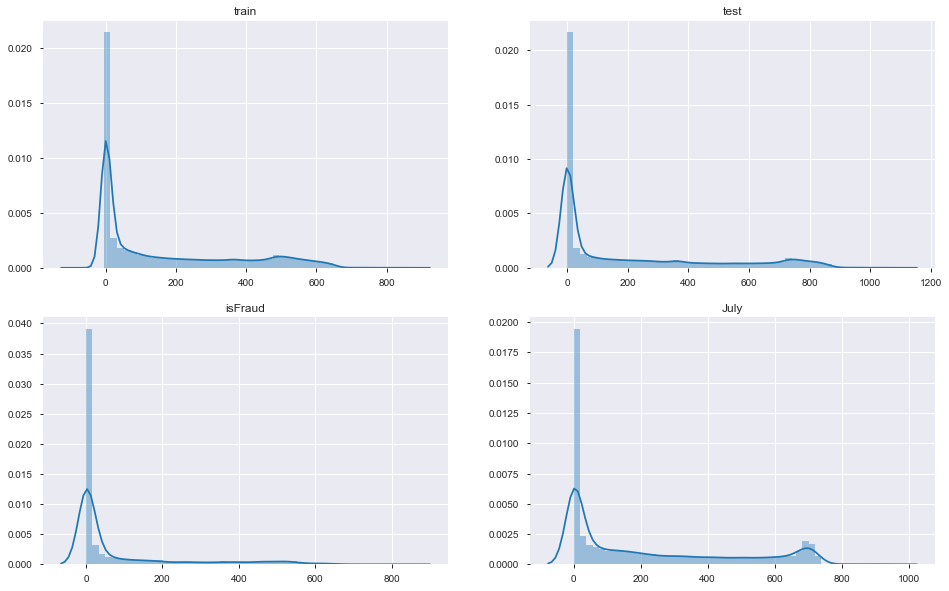

In [51]:
plot('D15')

### M1

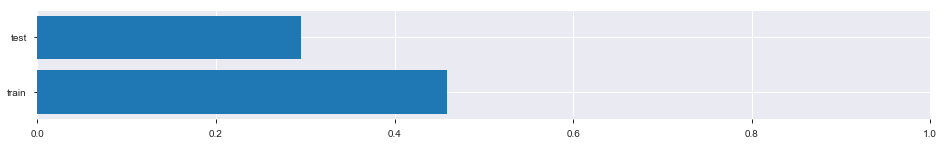

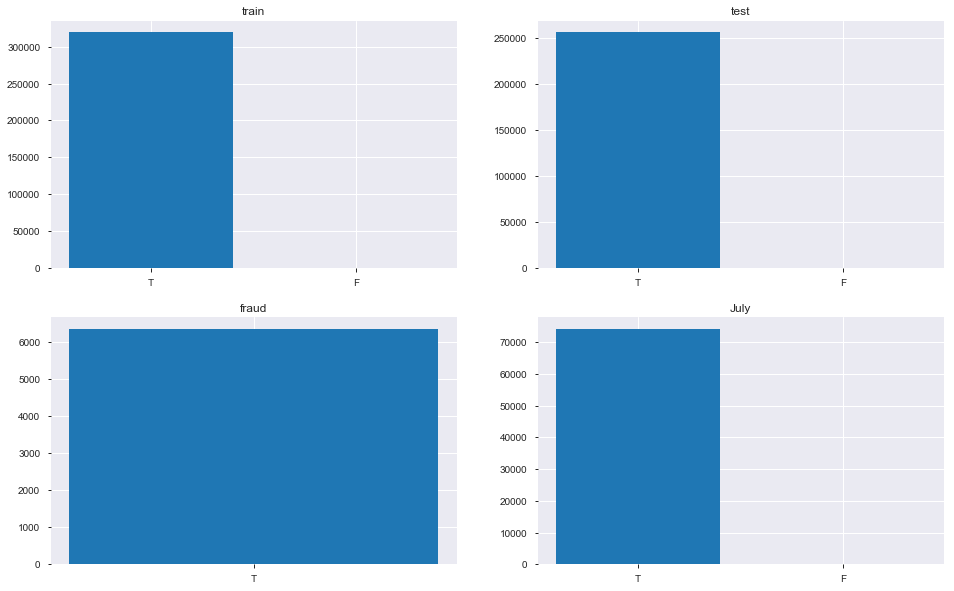

In [52]:
plot('M1')

### M2

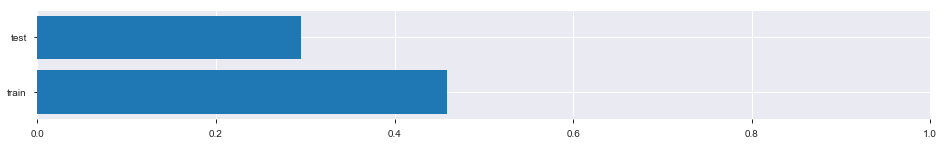

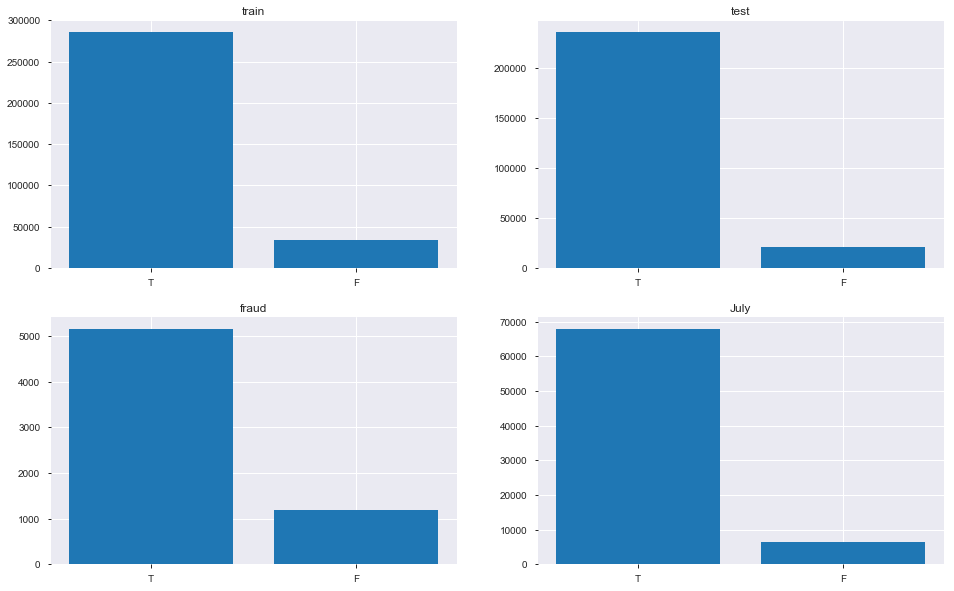

In [53]:
plot('M2')

### M3

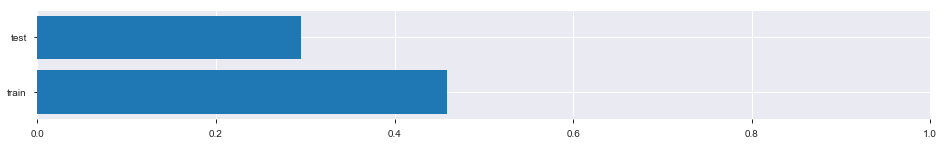

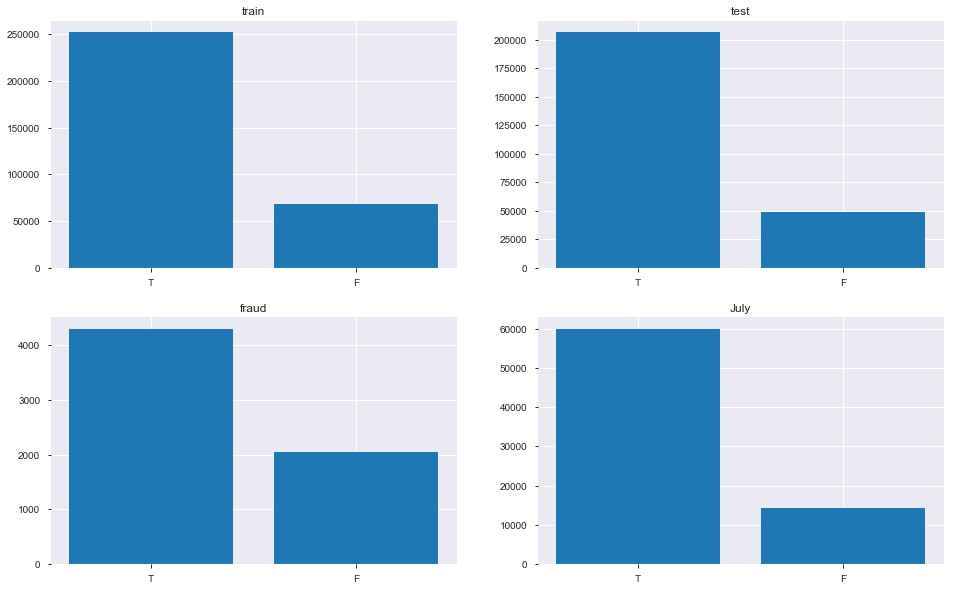

In [54]:
plot('M3')

### M4

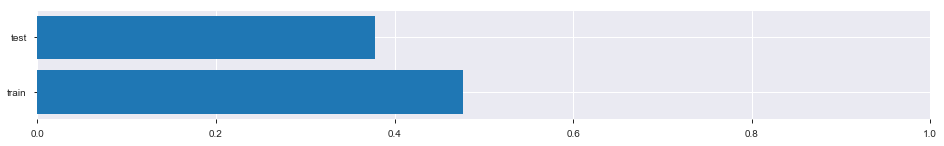

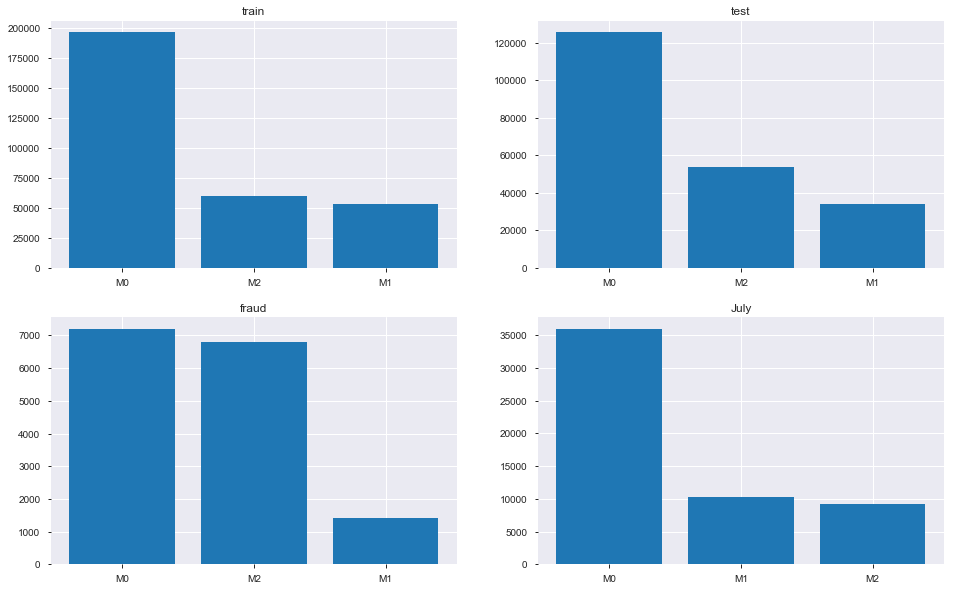

In [55]:
plot('M4')

### M5

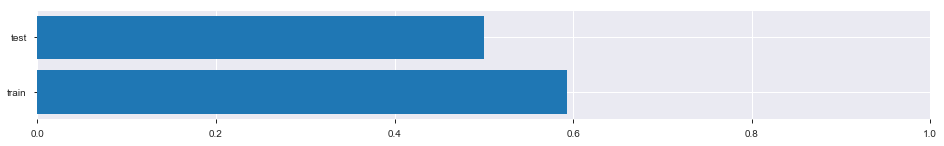

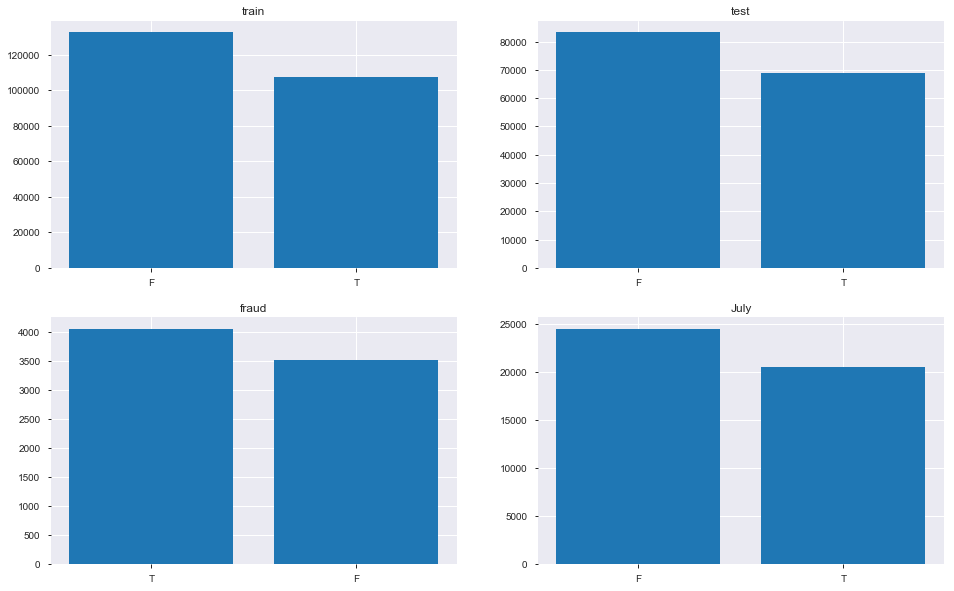

In [56]:
plot('M5')

### M6

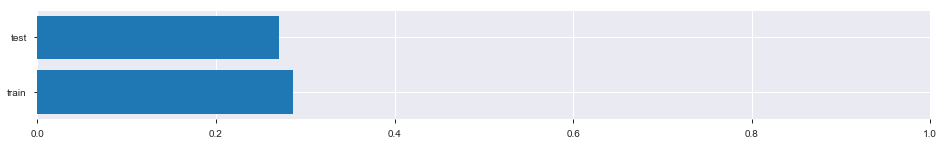

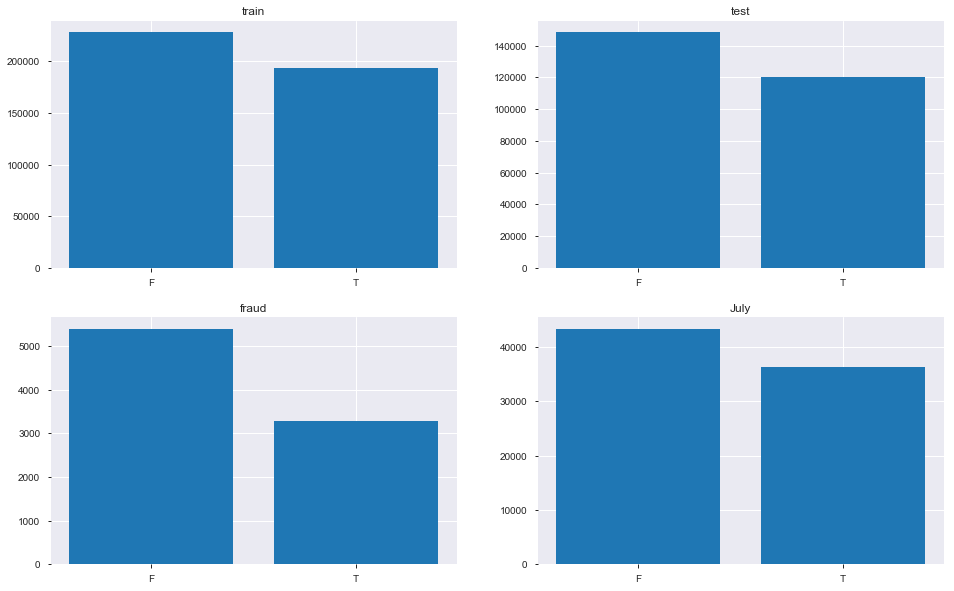

In [57]:
plot('M6')

### M7

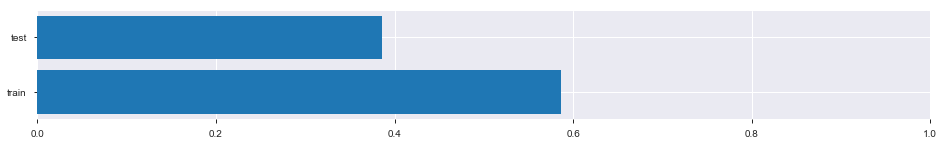

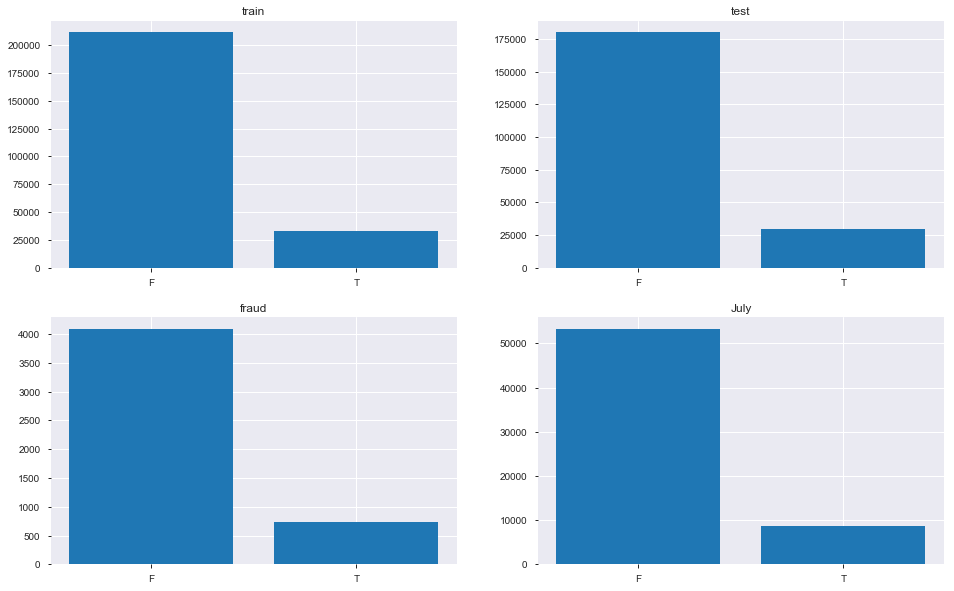

In [58]:
plot('M7')

### M8

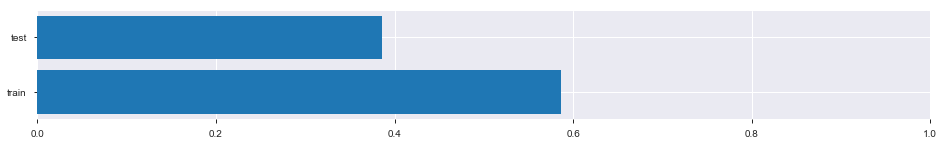

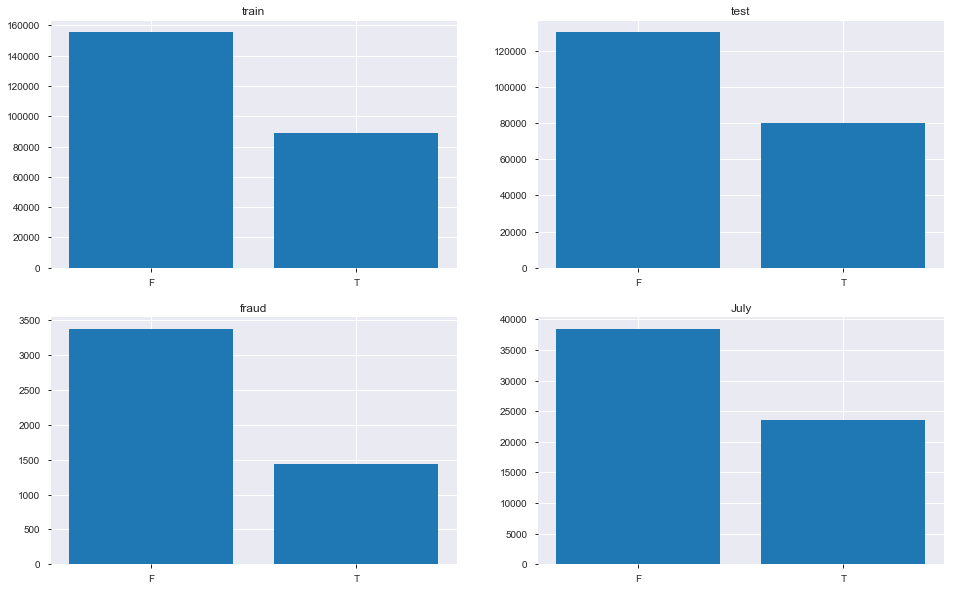

In [59]:
plot('M8')

### M9

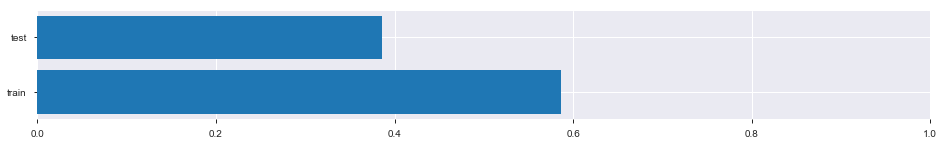

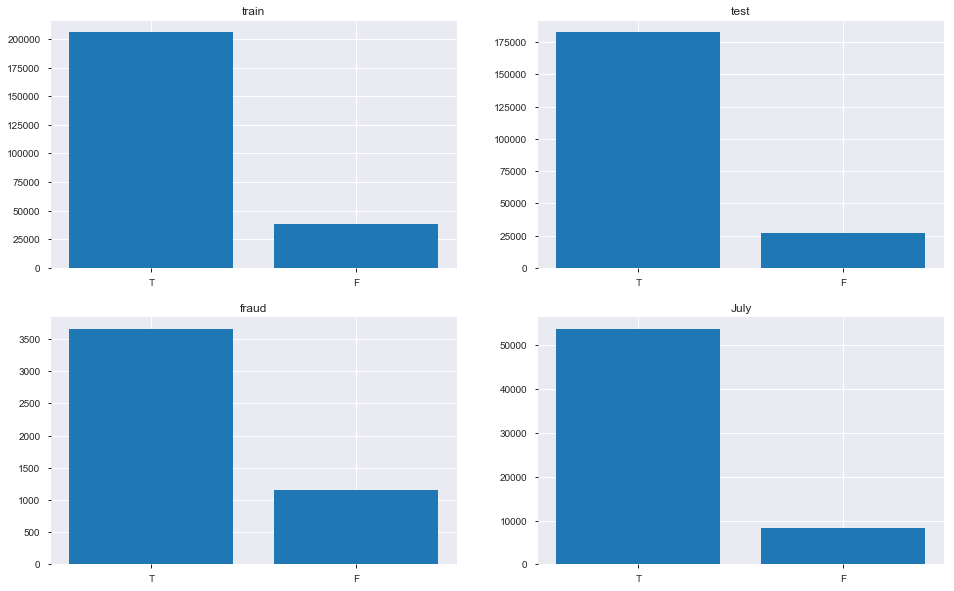

In [60]:
plot('M9')